In [ ]:
!pip install datasets


     |████████████████████████████████| 342 kB 15.6 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
     |████████████████████████████████| 212 kB 54.9 MB/s 
     |████████████████████████████████| 136 kB 71.9 MB/s 
     |████████████████████████████████| 1.1 MB 62.2 MB/s 
     |████████████████████████████████| 127 kB 73.4 MB/s 
     |████████████████████████████████| 94 kB 4.4 MB/s 
     |████████████████████████████████| 271 kB 75.1 MB/s 
     |████████████████████████████████| 144 kB 55.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
# !pip install torch==1.7.0
# !pip install torchtext==0.10.0

     |████████████████████████████████| 7.6 MB 26.9 MB/s 
     |████████████████████████████████| 831.4 MB 2.6 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.7.0
    Uninstalling torch-1.7.0:
      Successfully uninstalled torch-1.7.0
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.8.0
    Uninstalling torchtext-0.8.0:
      Successfully uninstalled torchtext-0.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.9.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.9.0 which is incompatible.
textattack 0.3.0 requires numpy<1.19.0, but you have numpy 1.21.6 which is incompatible.
textattack 0.3.0 requires torch==1.7.1, but you have torch 1.9.0 which is incompatible.


In [ ]:
from os import listdir
from os.path import isfile, join
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


df_train = pd.read_csv("train_dataset_final.csv")
df_test = pd.read_csv("test_dataset_final.csv")

df_train

,Unnamed: 0,text,class,lang
0,0,"10 fakta za Dzhanet Iel'n - zhenata, koiato ve...",0,bul
1,1,"11. Nie viarvame, che edna znachitelna chast o...",0,bul
2,2,120 khil. lv. biakha otkradnati kato na kino o...,0,bul
3,3,12:10 - t'rsiat Karbovski ot Sofiiskiia univer...,0,bul
4,4,12-godishno momichentse se obesi chas sled igr...,0,bul
...,...,...,...,...
80995,80995,Vielleicht verdienen diese Menschen oftmals au...,1,deu
80996,80996,Vielleicht wird diese eine der wenigen Moglich...,1,deu
80997,80997,"""Vielleicht wirkt so eine Verkurzung ja als Si...",1,deu
80998,80998,Vielleicht wurde der Norweger deshalb vom Publ...,1,deu


In [ ]:
df_train = df_train.rename({'class':'label'}, axis='columns')
df_test = df_test.rename({'class':'label'}, axis='columns')
df_test

,Unnamed: 0,text,label,lang
0,0,Tova s'obshchi vchera shefkata Vsichki prava z...,0,bul
1,1,Tova s'obshchi govoriteliat na TsIK Kameliia N...,0,bul
2,2,Tova s'obshchi za dezhurniiat sinoptik Martin ...,0,bul
3,3,Tova s'obshchi za Martina Tsvetanova - dezhure...,0,bul
4,4,"Tova s'obshchi za Radio ""Fokus"" - Varna d-r Pe...",0,bul
...,...,...,...,...
8995,8995,"Zwischen Regierungen, Unternehmen, Burgern und...",1,deu
8996,8996,Zwischen Schloss- und Kaiserstrasse wird sie a...,1,deu
8997,8997,Zwischen und nach den Auftritten wird die Band...,1,deu
8998,8998,Zwischenzeitlich rutschte er als Industrieller...,1,deu


In [ ]:
import functools
import sys

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
from datasets import Dataset

seed = 0

torch.manual_seed(seed)

In [ ]:
train_data = Dataset.from_pandas(df_train)
test_data = Dataset.from_pandas(df_test)

In [ ]:
train_data

Dataset({
    features: ['text', 'class', 'label'],
    num_rows: 5485
})

In [ ]:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

def tokenize_data(example, tokenizer, max_length):
    tokens = tokenizer(example['text'])[:max_length]
    return {'tokens': tokens}

max_length = 256

train_data = train_data.map(tokenize_data, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})
test_data = test_data.map(tokenize_data, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})

test_size = 0.25

valid_data = test_data

min_freq = 5
special_tokens = ['<unk>', '<pad>']

vocab = torchtext.vocab.build_vocab_from_iterator(train_data['tokens'],
                                                  min_freq=min_freq,
                                                  specials=special_tokens)


unk_index = vocab['<unk>']
pad_index = vocab['<pad>']

vocab.set_default_index(unk_index)

def numericalize_data(example, vocab):
    ids = [vocab[token] for token in example['tokens']]
    return {'ids': ids}

train_data = train_data.map(numericalize_data, fn_kwargs={'vocab': vocab})
valid_data = valid_data.map(numericalize_data, fn_kwargs={'vocab': vocab})
test_data = test_data.map(numericalize_data, fn_kwargs={'vocab': vocab})


print(test_data)
train_data = train_data.with_format(type='torch', columns=['ids', 'label'])
valid_data = valid_data.with_format(type='torch', columns=['ids', 'label'])
test_data = test_data.with_format(type='torch', columns=['ids', 'label'])

train_data[0]


  0%|          | 0/81000 [00:00<?, ?ex/s]

  0%|          | 0/9000 [00:00<?, ?ex/s]

  0%|          | 0/81000 [00:00<?, ?ex/s]

  0%|          | 0/9000 [00:00<?, ?ex/s]

  0%|          | 0/9000 [00:00<?, ?ex/s]

Dataset({
    features: ['Unnamed: 0', 'text', 'label', 'lang', 'tokens', 'ids'],
    num_rows: 9000
})


{'ids': tensor([  212,  9903,    44,     0,     0,     4,   143,    21,  8070,     3,
           536,  5435,   131,     0,     0,     0,    17,     4, 12831,    45,
             4, 25584,  6019,     0, 19641,  3895,    12,     0,   198,     4,
         16519,    12,  8525,    44,     0,     0,   642,   113,     4,     0,
             3, 13196,  2502,     0,    30,  1972,    12,  4915,     2]),
 'label': tensor(0)}

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout_rate, 
                 pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
    
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, ids):
        #text = [batch size, sent len]
        embedded = self.embedding(ids)
        #embedded = [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)
        #embedded = [batch size, 1, sent len, emb dim]
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        #pooled_n = [batch size, n_filters]
        cat = self.dropout(torch.cat(pooled, dim = 1))
        #cat = [batch size, n_filters * len(filter_sizes)]
        return self.fc(cat)

In [ ]:
vocab_size = len(vocab)
embedding_dim = 100
n_filters = 100
filter_sizes = [3,5,7]
output_dim = len(train_data.unique('label'))
dropout_rate = 0.25

model = CNN(vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout_rate, pad_index)



In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,328,409 trainable parameters


In [ ]:
model.init_weights()
# vectors = torchtext.vocab.GloVe(name='6B', dim=100)
# pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
# model.embedding.weight.data = pretrained_embedding

In [ ]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
# vectors = torchtext.vocab.FastText()
# pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
# model.embedding.weight.data = pretrained_embedding
lr = 5e-4

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)


def collate(batch, pad_index):
    batch_ids = [i['ids'] for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_label = [i['label'] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {'ids': batch_ids,
             'label': batch_label}
    return batch


batch_size = 512
collate = functools.partial(collate, pad_index=pad_index)
train_dataloader = torch.utils.data.DataLoader(train_data, 
                                               batch_size=batch_size, 
                                               collate_fn=collate, 
                                               shuffle=True)

valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=collate)


def train(dataloader, model, criterion, optimizer, device):

    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(dataloader, desc='training...', file=sys.stdout):
        ids = batch['ids'].to(device)
        label = batch['label'].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = categorical_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

def evaluate(dataloader, model, criterion, device):
    
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)
            label = batch['label'].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = categorical_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy



In [ ]:
n_epochs = 5
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(n_epochs):

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)
    
    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)
    
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'cnn.pt')
    
    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')

evaluating...: 100%|██████████| 18/18 [00:03<00:00,  5.99it/s]
epoch: 1
train_loss: 1.031, train_acc: 0.764
valid_loss: 0.261, valid_acc: 0.942
evaluating...: 100%|██████████| 18/18 [00:03<00:00,  5.68it/s]
epoch: 2
train_loss: 0.131, train_acc: 0.973
valid_loss: 0.096, valid_acc: 0.974
evaluating...: 100%|██████████| 18/18 [00:03<00:00,  5.93it/s]
epoch: 3
train_loss: 0.054, train_acc: 0.988
valid_loss: 0.060, valid_acc: 0.983
evaluating...: 100%|██████████| 18/18 [00:03<00:00,  5.92it/s]
epoch: 4
train_loss: 0.030, train_acc: 0.994
valid_loss: 0.044, valid_acc: 0.987
evaluating...: 100%|██████████| 18/18 [00:02<00:00,  6.01it/s]
epoch: 5
train_loss: 0.018, train_acc: 0.997
valid_loss: 0.036, valid_acc: 0.989


Text(0, 0.5, 'loss')

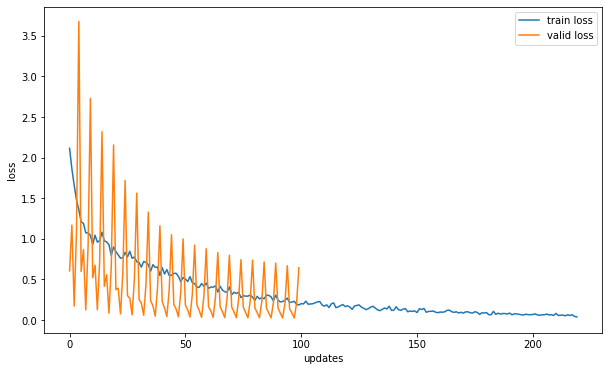

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

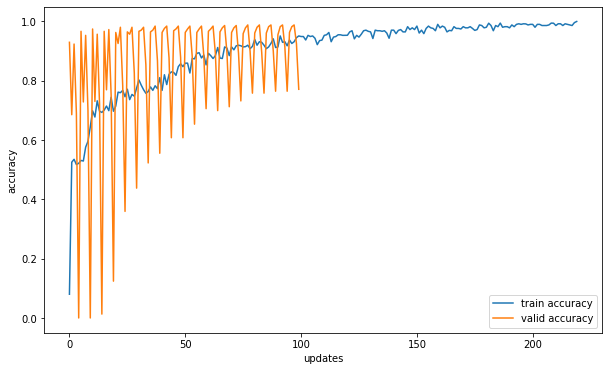

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='train accuracy')
ax.plot(valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('accuracy');

In [ ]:
model.load_state_dict(torch.load('cnn.pt'))

test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)

print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')

evaluating...: 100%|██████████| 18/18 [00:03<00:00,  5.93it/s]
test_loss: 0.036, test_acc: 0.989


In [ ]:
min_length=7

In [ ]:
def predict_class(text, model, tokenizer, vocab, device, min_length, pad_index):
    tokens = tokenizer(text)
    ids = [vocab[t] for t in tokens]
    if len(ids) < min_length:
        ids += [pad_index] * (min_length - len(ids))
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [ ]:
text = "With cas, we must assurance that, if we offers report on Members' activities, affirm, that such informations is complete."

predict_class(text, model, tokenizer, vocab, device, min_length, pad_index)

(2, 0.999862551689148)

In [ ]:
max(filter_sizes)

7

In [ ]:
!pip install textattack
!pip install tensorflow_text

     |████████████████████████████████| 373 kB 14.1 MB/s 
     |████████████████████████████████| 4.0 MB 60.3 MB/s 
     |████████████████████████████████| 401 kB 75.5 MB/s 
     |████████████████████████████████| 101 kB 11.9 MB/s 
     |████████████████████████████████| 769 kB 61.6 MB/s 
     |████████████████████████████████| 69 kB 10.1 MB/s 
     |████████████████████████████████| 60 kB 9.1 MB/s 
     |████████████████████████████████| 6.6 MB 52.6 MB/s 
     |████████████████████████████████| 596 kB 72.9 MB/s 
     |████████████████████████████████| 895 kB 64.1 MB/s 
     |████████████████████████████████| 325 kB 62.6 MB/s 
     |████████████████████████████████| 312 kB 74.6 MB/s 
     |████████████████████████████████| 311 kB 71.0 MB/s 
     |████████████████████████████████| 312 kB 78.6 MB/s 
     |████████████████████████████████| 311 kB 75.7 MB/s 
     |████████████████████████████████| 311 kB 76.3 MB/s 
     |████████████████████████████████| 306 kB 71.0 MB/s 
     |███████████

     |████████████████████████████████| 4.9 MB 15.4 MB/s 
     |████████████████████████████████| 462 kB 64.8 MB/s 
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 3.10.1
    Uninstalling importlib-metadata-3.10.1:
      Successfully uninstalled importlib-metadata-3.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
konoha 4.6.5 requires importlib-metadata<4.0.0,>=3.7.0, but you have importlib-metadata 4.11.3 which is incompatible.


In [ ]:
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
min_length = 7
# predictions = model.predict(["The movie was not good. The animation and the graphics"])
import textattack

import numpy as np
import torch
from textattack.models.wrappers import ModelWrapper

class CustomPytorchModelWrapper(ModelWrapper):
    def __init__(self, model, tokenizer, vocab):
        self.model = model
        self.tokenizer = tokenizer
        self.vocab = vocab
    def __call__(self, text_input_list):
        probabilities = []
        for text in text_input_list:
          tokens = tokenizer(text)
          ids = [vocab[t] for t in tokens]
          if len(ids) < min_length:
              ids += [pad_index] * (min_length - len(ids))
          tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
          prediction = model(tensor).squeeze(dim=0)
          probability = torch.softmax(prediction, dim=-1)
          probability = probability.cpu().detach().numpy()
          probabilities.append(probability)
        return probabilities

model_wrapper = CustomPytorchModelWrapper(model, tokenizer, vocab)

textattack: Updating TextAttack package dependencies.
textattack: Downloading NLTK required packages.


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


textattack: Downloading https://textattack.s3.amazonaws.com/word_embeddings/paragramcf.
100%|██████████| 481M/481M [00:19<00:00, 24.9MB/s]
textattack: Unzipping file /root/.cache/textattack/tmpcvlk6z4u.zip to /root/.cache/textattack/word_embeddings/paragramcf.
textattack: Successfully saved word_embeddings/paragramcf to cache.


In [ ]:
import textattack
df_attack = pd.read_csv("attack_test_data.csv")

data = []
for index, row in df_attack.iterrows():
    data.append((row['text'], row['class']))

# df_attack_2 = pd.read_csv("attack_dataset_8_classes_2.csv")
# for index, row in df_attack_2.iterrows():
#     data.append((row['text'], row['label']))
    
dataset = textattack.datasets.Dataset(data)

In [ ]:
from textattack.attack_recipes import TextFoolerJin2019, PWWSRen2019, DeepWordBugGao2018, GeneticAlgorithmAlzantot2018
from textattack import Attacker
from textattack import AttackArgs

# dataset = custom_dataset
attack = DeepWordBugGao2018.build(model_wrapper)
attack_args = AttackArgs(num_examples=200, log_to_csv="cnn_attack_deepwordbug_lang_recog.csv")
attacker = Attacker(attack, dataset, attack_args)
attacker.attack_dataset()

textattack: Unknown if model of class <class '__main__.CNN'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path cnn_attack_deepwordbug_lang_recog.csv


Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  30
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/textattack/goal_functions/classification/classification_goal_function.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  scores = torch.tensor(scores)
[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:   0%|          | 1/200 [00:00<00:18, 10.60it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

United Kingdom and United States sanctions against Zimbabwe illustrate the "warm-up" approach, followed by a "knock-out" punch.





[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:   1%|          | 2/200 [00:00<00:24,  8.24it/s]

--------------------------------------------- Result 2 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While presenting the report, Hon. Bright pleaded that in view of the sacrifices Mrs. Jonathan's husband made for the country while he was president, the House should wade into the matter and call the security agencies to order.





[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:   2%|▏         | 4/200 [00:00<00:19, 10.01it/s]

--------------------------------------------- Result 3 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"You have the two extremes as far as different reasons for crop insurance," he said.



--------------------------------------------- Result 4 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While the nation has seen 7.6 percent job growth since 2013, Kansas has lagged far behind, with an anemic rate of 3.5 percent.





[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:   2%|▎         | 5/200 [00:00<00:19,  9.95it/s]

--------------------------------------------- Result 5 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

WASHINGTON, D.C. -- President George Bush has praised efforts by Colombian President Alvaro Uribe to crack down on terrorism in the South American country.





[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:   4%|▎         | 7/200 [00:00<00:18, 10.16it/s]

--------------------------------------------- Result 6 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While the federal government is up and running, at least for a few weeks, many Greenbelters felt the stress of preparing for a shutdown.



--------------------------------------------- Result 7 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Your insistence, your determination to stick to your opinion in the face of all the new evidence makes you look like a closed-mined idiot.





[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10:   5%|▌         | 10/200 [00:00<00:18, 10.36it/s]

--------------------------------------------- Result 8 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"When we say the rule of law doesn't apply because you are not a U.S. citizen, when we say it doesn't apply because you've admitted killing people, then the rule of law doesn't apply to all of us."



--------------------------------------------- Result 9 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"Yet he has not once told the public about the child abuse allegations he faced in 2007 and the discretionary decisions of my office, and more specifically by me as the DA."



--------------------------------------------- Result 10 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With about 30 percent of carbon emissions coming from the fossil fuel.





[Succeeded / Failed / Skipped / Total] 0 / 13 / 0 / 13:   6%|▋         | 13/200 [00:01<00:17, 10.66it/s]

--------------------------------------------- Result 11 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

You'll be able to choose to play as either the male Alexios or the female Kassandra, both of whom are Spartan "outcasts-turned-mercenaries" who appear to have joined the Assassins Brotherhood.



--------------------------------------------- Result 12 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"Under the EU mechanism for distributing 160,000 refugees Hungary would have to take in just 1,294 people currently living in Greece and Italy.



--------------------------------------------- Result 13 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are going to have this demonstration tomorrow, it's a peaceful protest.





[Succeeded / Failed / Skipped / Total] 0 / 16 / 0 / 16:   8%|▊         | 16/200 [00:01<00:17, 10.40it/s]

--------------------------------------------- Result 14 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

YouTuber Logan Paul says sorry after posting sickening video of suicide victim hanging from a treeThe American vlogger is hugely popular with children and he provoked outrage after he uploaded the video to his 15 million followers.



--------------------------------------------- Result 15 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Who ever is DPM now will take the office of the PM.



--------------------------------------------- Result 16 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We've also previously told you how the health board has flown in consultants from Europe and as far as the Middle East to plug gaps within the service.





[Succeeded / Failed / Skipped / Total] 0 / 18 / 0 / 18:   9%|▉         | 18/200 [00:01<00:17, 10.39it/s]

--------------------------------------------- Result 17 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are in the hospital suffering," Deivis' mother, Sandra Galindez, told me and my colleagues.



--------------------------------------------- Result 18 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While the menu has expanded to pizzas and other items in the past decade, Fatiga's strength -- and what makes it one of the truly best eating experiences in Arkansas -- is its selection of Italian subs.





[Succeeded / Failed / Skipped / Total] 0 / 20 / 0 / 20:  10%|█         | 20/200 [00:01<00:17, 10.49it/s]

--------------------------------------------- Result 19 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"You can do far more than you ever expected if you just push yourself and keep going, and if someone tells you no, you just continue on."



--------------------------------------------- Result 20 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"What makes the F1 in Schools Technology Challenge different," said Mr Sangari, "is that it entails a comprehensive and inclusive learning approach.





[Succeeded / Failed / Skipped / Total] 0 / 23 / 0 / 23:  12%|█▏        | 23/200 [00:02<00:16, 10.49it/s]

--------------------------------------------- Result 21 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Washington has shown signs of shrugging off its role as a world leader, and nations such as Russia and China, which do not see Western humanitarian values as universal, wield growing global clout.



--------------------------------------------- Result 22 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While fewer people may have died in Las Vegas if bump stocks were banned, the devices have rarely, if ever, been used in prior shootings.



--------------------------------------------- Result 23 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When a dispute occurred, the latter asked for the return of the deposits.





[Succeeded / Failed / Skipped / Total] 1 / 26 / 0 / 27:  14%|█▎        | 27/200 [00:02<00:15, 10.99it/s]

--------------------------------------------- Result 24 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When Uber came to Sri Lanka they will use someone else's assets though it is over Uber's arrival that we will have a big bash!



--------------------------------------------- Result 25 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We'll see a bigger cool down and the chance for some heavy snow across parts of Colorado.



--------------------------------------------- Result 26 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What I learned about Budapest the morning we arrived was that it hid some secret gardens we were about to discover.



--------------------------------------------- Result 27 ---------------------------------------------
[[2 (97%)]] --> [[0 (48%)]]

Wildflower, from that [[day]] forward, excelled almost [[like]] no dog I've ever trained.


Wildflower, from that [[daC]] forwar

[Succeeded / Failed / Skipped / Total] 1 / 29 / 0 / 30:  15%|█▌        | 30/200 [00:02<00:15, 11.08it/s]

--------------------------------------------- Result 28 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"What we're trying to do, is we're trying to build up our capacity to do projects with the Ring of Fire."



--------------------------------------------- Result 29 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While proponents of the legislation argued the existing regulations hindered economic growth, conservationists fear the price paid for environmental degradation is often lost in the debate.



--------------------------------------------- Result 30 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We desperately need to spend more on health, public services and education.





[Succeeded / Failed / Skipped / Total] 1 / 31 / 0 / 32:  16%|█▌        | 32/200 [00:02<00:15, 11.12it/s]

--------------------------------------------- Result 31 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

You chose to think of materialism and greed when you walk through those "heavy glass doors."



--------------------------------------------- Result 32 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We also plan to grow in the business, at the moment in 2010 the capacity is 3.2 MMt but we expected to 5.3 MMt by Q1'11 and 5.8 MMt by end of 2011.





[Succeeded / Failed / Skipped / Total] 1 / 34 / 0 / 35:  18%|█▊        | 35/200 [00:03<00:15, 10.89it/s]

--------------------------------------------- Result 33 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Zhu Xiaohu, founder of GSR Ventures, said at a speech in April that mini programs will overturn the giants of PC and mobile Internet, and that total investment in mini programs could reach the tens of billions of yuan this year.



--------------------------------------------- Result 34 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What's to keep corporate interests from complaining that our land use laws are at variance with future congressional legisltion, affect inter-state commerce, and don't have to be followed by out of state developers?



--------------------------------------------- Result 35 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When a person dies, his soul passes on to the next World.





[Succeeded / Failed / Skipped / Total] 1 / 36 / 0 / 37:  18%|█▊        | 37/200 [00:03<00:15, 10.83it/s]

--------------------------------------------- Result 36 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We've got to do a good job of selling our kids on what we're trying to do and what we're trying to build at Smiths Station.



--------------------------------------------- Result 37 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Your next chance to see the team is tomorrow (Tuesday) night at the Brindy, when they again take on the Glacier Kings before heading down-Island for a rematch against Oceanside Friday night.





[Succeeded / Failed / Skipped / Total] 1 / 39 / 0 / 40:  20%|██        | 40/200 [00:03<00:14, 10.82it/s]

--------------------------------------------- Result 38 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Yet when Ponderosa swept Longmont just as they had Berthoud earlier in the day, Berthoud was consigned to the fact that the next day's match, their final of the season, would be for nothing but pride.



--------------------------------------------- Result 39 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Where were these investors when public fund was being committed to the same project?



--------------------------------------------- Result 40 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What I can't find anywhere online is the names of the photographers in the exhibition -- I'd run their names if I could find them all.





[Succeeded / Failed / Skipped / Total] 1 / 42 / 0 / 43:  22%|██▏       | 44/200 [00:03<00:14, 11.11it/s]

--------------------------------------------- Result 41 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Walk north on Cadman, past some mansions built on the leafy hillside, and enter the woods.



--------------------------------------------- Result 42 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While it contained methylone, a chemical nearly identical to MDMA, it was a different drug altogether.



--------------------------------------------- Result 43 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are running more and more trains all the time and that is what is causing the problem, the capacity on the track.





[Succeeded / Failed / Skipped / Total] 1 / 45 / 0 / 46:  23%|██▎       | 46/200 [00:04<00:13, 11.16it/s]

--------------------------------------------- Result 44 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With older artists, the law of diminishing returns often applies, and it's sad when our musical heroes overstay their welcome.



--------------------------------------------- Result 45 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We hope Malala can avoid being manipulated on China-related issues while striving for education equality and the global human rights cause.



--------------------------------------------- Result 46 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We don't receive any inspections from the Ministry of Manpower in these hills, as these quarries are part of the informal sector.





[Succeeded / Failed / Skipped / Total] 1 / 47 / 0 / 48:  24%|██▍       | 48/200 [00:04<00:13, 11.20it/s]

--------------------------------------------- Result 47 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Vince Cate visited the Sandy Ground site and reports that they are finding a great deal of Amerindian material.



--------------------------------------------- Result 48 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We got a goot chance to look at a lot of kids and most of them got a lot of playing time."





[Succeeded / Failed / Skipped / Total] 1 / 50 / 0 / 51:  26%|██▌       | 51/200 [00:04<00:13, 11.14it/s]

--------------------------------------------- Result 49 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Vancouver lawyer Kyla Lee and her firm, Acumen Law Corp., claimed at trial that a Google Plus review calling her the "worstest lawyer" led to a decline in client calls.



--------------------------------------------- Result 50 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While the kingdom has borrowed heavily on the Saudi money markets, it can easily float sovereign debt on the international debt market to ease its domestic credit crunch.



--------------------------------------------- Result 51 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Will people need to go to the electoral district to vote?





[Succeeded / Failed / Skipped / Total] 1 / 53 / 0 / 54:  27%|██▋       | 54/200 [00:04<00:13, 11.15it/s]

--------------------------------------------- Result 52 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We are extremely honored to win this award, as we feel it really highlights our efforts to make it easier for our EuroBonus members to access and redeem their points.



--------------------------------------------- Result 53 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When the next chance came his way he slotted coolly into the top right corner.



--------------------------------------------- Result 54 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

You should be known to be producing from information gathered from either extension officers or records from the Grain Marketing Board and one should have an offer letter."





[Succeeded / Failed / Skipped / Total] 1 / 55 / 0 / 56:  28%|██▊       | 56/200 [00:05<00:13, 11.06it/s]

--------------------------------------------- Result 55 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

You can go outside and go for a walk or a run without shivering the entire time.



--------------------------------------------- Result 56 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While living at the lodge in the early 1960s, Fox was hired by the former Burnet County Judge to help sell lots for a new subdivision on the lake at Granite Shoals (later renamed Lake LBJ).





[Succeeded / Failed / Skipped / Total] 1 / 58 / 0 / 59:  30%|██▉       | 59/200 [00:05<00:12, 11.14it/s]

--------------------------------------------- Result 57 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We also held three seminars and a special meeting of the board of directors to discuss the theme.



--------------------------------------------- Result 58 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We were by the water comparing our swimwear and laughing about how ill-fitting and unsupportive our contraptions were," the pair told news.



--------------------------------------------- Result 59 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Whether Asset Value Investors would hold onto their TBS shares after its demand was accepted "depends on how the valuation goes."





[Succeeded / Failed / Skipped / Total] 1 / 61 / 0 / 62:  31%|███       | 62/200 [00:05<00:12, 11.02it/s]

--------------------------------------------- Result 60 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We have also met the panchayat minister to brief him about how the compound wall of the church of this sect is of a height above the permissible limit.



--------------------------------------------- Result 61 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Various congressional committees worked on drafting multiple versions of the bill that would become the Affordable Care Act -- a lengthy process that took over a year.



--------------------------------------------- Result 62 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Various religious backgrounds will be represented as people from all over the U.S. and Canada travel to John Brown University to attend the Paradosis Conference.





[Succeeded / Failed / Skipped / Total] 1 / 64 / 0 / 65:  32%|███▎      | 65/200 [00:05<00:12, 11.10it/s]

--------------------------------------------- Result 63 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"Unions can be reactive, but if we could be proactive, then we would be happy to have discussions.



--------------------------------------------- Result 64 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Unfortunately people's true mandate was not reflected in the allocation of seats due to unrealistic and horrendous proportionate system.



--------------------------------------------- Result 65 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

University Union hosted their annual Block Party in the Carrier Dome on Friday night, featuring DJ Orange Calderon, SZA and Gucci Mane.





[Succeeded / Failed / Skipped / Total] 1 / 66 / 0 / 67:  34%|███▎      | 67/200 [00:06<00:12, 11.07it/s]

--------------------------------------------- Result 66 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We've recently finished a fabulous office makeover, and we're having an open house to show it off," said agency director Ronda B. Goldfein.



--------------------------------------------- Result 67 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Youth mental health, suicide and bullying was thrust in to the national spotlight following the highly-publicised death of 14-year-old Amy 'Dolly' Everett in January.





[Succeeded / Failed / Skipped / Total] 1 / 68 / 0 / 69:  34%|███▍      | 69/200 [00:06<00:12, 10.84it/s]

--------------------------------------------- Result 68 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

William and Kate Middleton's daughter was born at St. Mary's Hospital on May 2. Just 10 hours after giving birth, the Duchess of Cambridge left the hospital looking gorgeous in a floral white and yellow Jenny Packman dress.



--------------------------------------------- Result 69 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We will keep monitoring the situation and make sure that we will be able to maintain the drive for the growth so that we could assure our target of trimming off poverty at the rate of 1% per annum.





[Succeeded / Failed / Skipped / Total] 1 / 71 / 0 / 72:  36%|███▌      | 72/200 [00:06<00:11, 10.78it/s]

--------------------------------------------- Result 70 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"You would be surprised how many people will drive in from an hour or two hours away to come in and spend an afternoon at Great Shots," North said.



--------------------------------------------- Result 71 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Usage of a time fuse also seems out of the question, since not only the murderers, but also Vazagashvili himself likely didn't know when he would arrive at his son's grave.



--------------------------------------------- Result 72 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"You are not a little dictator to do whatever you want - and that's what we have right now in Houston, Texas," he said.





[Succeeded / Failed / Skipped / Total] 1 / 74 / 0 / 75:  38%|███▊      | 75/200 [00:06<00:11, 10.82it/s]

--------------------------------------------- Result 73 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Until the government receives confirmation of e-cigarette benefits, it would continue treating them as other tobacco products.



--------------------------------------------- Result 74 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We hope that it will initiate a more informed debate about what represents fair, proportionate pay for workers at all levels," he said.



--------------------------------------------- Result 75 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What we asked from RMB in our previous letter, was "a guarantee from your bank that your capital not be used for the illegal oil exploration in the occupied country".





[Succeeded / Failed / Skipped / Total] 1 / 77 / 0 / 78:  39%|███▉      | 78/200 [00:07<00:11, 10.95it/s]

--------------------------------------------- Result 76 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Visitors will also be treated to a top-notch, interactive trick rope show.



--------------------------------------------- Result 77 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With the summer fast approaching, you're sure to be spending lots of time outdoors.



--------------------------------------------- Result 78 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While they are working to tackle crime, they won't guarantee that the money you invest will be 'safe' in every sense of the word.





[Succeeded / Failed / Skipped / Total] 1 / 79 / 0 / 80:  40%|████      | 80/200 [00:07<00:11, 10.86it/s]

--------------------------------------------- Result 79 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

You wouldn't go to buy fighter jets because there is no possibility of creating a balance of power against "Israel" on that level, instead you would go buy air defense systems.



--------------------------------------------- Result 80 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When asked about funding concerns before the Senate vote on the Mission Act, key lawmakers who helped pass the bill claimed it wouldn't be a challenge.





[Succeeded / Failed / Skipped / Total] 1 / 82 / 0 / 83:  42%|████▏     | 83/200 [00:07<00:10, 10.78it/s]

--------------------------------------------- Result 81 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Victoria Vivians scored 22 points and second-ranked Mississippi State remained in position to add a Southeastern Conference Tournament title to its regular-season championship, beating No. 15 Texas A&M 70-55 on.



--------------------------------------------- Result 82 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We expected a tough beginning but still believed we could play in the finals, which we did.



--------------------------------------------- Result 83 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While today's sea level rise is only about 10% the rate about 13,000 years ago, it is expected to rise rapidly in the coming years, notes the report.





[Succeeded / Failed / Skipped / Total] 1 / 84 / 0 / 85:  42%|████▎     | 85/200 [00:07<00:10, 10.63it/s]

--------------------------------------------- Result 84 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With changes to GATE, many are wondering if they're going to get funding and with the recent scare of an old memo being leaked, fears were raised.



--------------------------------------------- Result 85 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When coming from Tanzania, lifts depart from Mtwara and Kilambo to the Rovuma river.





[Succeeded / Failed / Skipped / Total] 1 / 86 / 0 / 87:  44%|████▎     | 87/200 [00:08<00:10, 10.47it/s]

--------------------------------------------- Result 86 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We want to deliver your $2.5 million to you before your bank closes, so you can put it in a safe place.



--------------------------------------------- Result 87 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What is floated right now will come back, perhaps in a watered-down version, but the progressives will keep coming after you.





[Succeeded / Failed / Skipped / Total] 1 / 87 / 0 / 88:  44%|████▍     | 88/200 [00:08<00:10, 10.28it/s]

--------------------------------------------- Result 88 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What the suit calls the pharmaceutical's "aggressive marketing," the sheriff and his attorney feel have contributed to the rise in opioid use, addiction and overdose.





[Succeeded / Failed / Skipped / Total] 1 / 89 / 0 / 90:  45%|████▌     | 90/200 [00:08<00:10, 10.12it/s]

--------------------------------------------- Result 89 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We share border with other countries and cannot afford to just point finger at whichever direction.



--------------------------------------------- Result 90 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We came out in the third period, we were ready to play, and we had some unlucky bounces.





[Succeeded / Failed / Skipped / Total] 1 / 91 / 0 / 92:  46%|████▌     | 92/200 [00:09<00:10, 10.09it/s]

--------------------------------------------- Result 91 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We're just good friends, and he's been incredibly loyal to me," Paxton in a 1998 interview.



--------------------------------------------- Result 92 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Where can you ask questions and talk about bullying, harassment and discrimination on campus?





[Succeeded / Failed / Skipped / Total] 1 / 94 / 0 / 95:  48%|████▊     | 95/200 [00:09<00:10, 10.03it/s]

--------------------------------------------- Result 93 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Wisdom's small plot, a few steps from his front step, is located right beside the main road in the community.



--------------------------------------------- Result 94 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Women invited her to their homes to deliver lectures on religious subjects.



--------------------------------------------- Result 95 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Whoever that was, I don't know any names or who that family was," Berube says.





[Succeeded / Failed / Skipped / Total] 1 / 95 / 0 / 96:  48%|████▊     | 96/200 [00:09<00:10,  9.98it/s]

--------------------------------------------- Result 96 ---------------------------------------------
[[2 (99%)]] --> [[[FAILED]]]

Wellness Medical Supplies offers medical equipment rental options for those in need of short-term assistance.





[Succeeded / Failed / Skipped / Total] 1 / 97 / 0 / 98:  49%|████▉     | 98/200 [00:09<00:10,  9.87it/s]

--------------------------------------------- Result 97 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We have a couple of our junior members that have came in just for certain particular roles that required a younger cast member for," said Smith.



--------------------------------------------- Result 98 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Your information will be saved and you can get the SIM card legally.





[Succeeded / Failed / Skipped / Total] 1 / 99 / 0 / 100:  50%|█████     | 100/200 [00:10<00:10,  9.69it/s]

--------------------------------------------- Result 99 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Very close friends of the family would always come from Pittsburgh to visit and we would spend the day and evening together.



--------------------------------------------- Result 100 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

You know how in the most somber of situations something happens that makes you almost want to giggle?





[Succeeded / Failed / Skipped / Total] 1 / 101 / 0 / 102:  51%|█████     | 102/200 [00:10<00:10,  9.42it/s]

--------------------------------------------- Result 101 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We want to create new ways for students to get involved where they feel they contribute in the way we operate, or in ideas they can bring forward to us," said Hartung.



--------------------------------------------- Result 102 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With his wife's diagnosis of ovarian cancer in the 2000s, the nursery became more difficult to keep up with.





[Succeeded / Failed / Skipped / Total] 1 / 102 / 0 / 103:  52%|█████▏    | 103/200 [00:10<00:10,  9.36it/s]

--------------------------------------------- Result 103 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Youths are comparable to bamboo shoots, as they will become the country's future leaders and officials.





[Succeeded / Failed / Skipped / Total] 1 / 104 / 0 / 105:  52%|█████▎    | 105/200 [00:11<00:10,  9.23it/s]

--------------------------------------------- Result 104 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We stand with communities across Colorado in calling on Governor Hickenlooper and the state legislature to reject any legislation that will undermine local control."



--------------------------------------------- Result 105 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Were they considered likely to succeed or more of a long shot?





[Succeeded / Failed / Skipped / Total] 2 / 106 / 0 / 108:  54%|█████▍    | 108/200 [00:11<00:10,  9.20it/s]

--------------------------------------------- Result 106 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Wahlberg was also part of a number of concentrated efforts to revitalize downtown Bay Shore over the years.



--------------------------------------------- Result 107 ---------------------------------------------
[[2 (100%)]] --> [[4 (64%)]]

"You [[get]] a cycle where [[one]] thing [[leads]] to the other."


"You [[et]] a cycle where [[ne]] thing [[eads]] to the other."



--------------------------------------------- Result 108 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Yesterday, protestors were met with a small scale counter-protest led by Georgian March, a far-right, ultra-nationalist, neo-nazi group that has a history of staging counter demonstrations and threatening violence.





[Succeeded / Failed / Skipped / Total] 2 / 108 / 0 / 110:  55%|█████▌    | 110/200 [00:11<00:09,  9.23it/s]

--------------------------------------------- Result 109 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What the servant owed the master is expressed as a myriad of talents.



--------------------------------------------- Result 110 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We made an effort to promote relations between Iran and Brazil in public and private sectors and we are capable of having useful bilateral relations," he concluded.





[Succeeded / Failed / Skipped / Total] 2 / 112 / 0 / 114:  57%|█████▋    | 114/200 [00:12<00:09,  9.34it/s]

--------------------------------------------- Result 111 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We made changes in terms of the shape and dynamic of the team at half-time and I thought the boys were brilliant in the second half.



--------------------------------------------- Result 112 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Your the only Santa and that makes you special to me!



--------------------------------------------- Result 113 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Welcoming the probe, he said the truth would finally come out now and Khaunte would ultimately be exposed.



--------------------------------------------- Result 114 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"When that's all they're living in then that's how they perceive the world to be," she said of the children in her care.





[Succeeded / Failed / Skipped / Total] 2 / 115 / 0 / 117:  58%|█████▊    | 117/200 [00:12<00:08,  9.43it/s]

--------------------------------------------- Result 115 ---------------------------------------------
[[2 (98%)]] --> [[[FAILED]]]

Youth unemployment in Australia is currently sitting at 13.3 per cent.



--------------------------------------------- Result 116 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Winners accumulate points for the next edition, where the winners of the 2017 circuit are defined.



--------------------------------------------- Result 117 ---------------------------------------------
[[2 (99%)]] --> [[[FAILED]]]

Wednesday, August 16, 2017Excitedly families stood in anticipation as the food packages were distributed.





[Succeeded / Failed / Skipped / Total] 2 / 119 / 0 / 121:  60%|██████    | 121/200 [00:12<00:08,  9.53it/s]

--------------------------------------------- Result 118 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Under Carpenter's plan, the Freda Markley Center and Ervin (expected to be renamed the Ervin Early Learning Center) will house pre-school and kindergarten students.



--------------------------------------------- Result 119 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

You are doing a sport that any able-bodied person can do.



--------------------------------------------- Result 120 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are also going to build a 200ft pier into the sea and that will be a 200 ft by 30 ft pier and that will allow for interaction with the water.



--------------------------------------------- Result 121 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are delighted that Ballinamore have come on board this year.





[Succeeded / Failed / Skipped / Total] 2 / 123 / 0 / 125:  62%|██████▎   | 125/200 [00:12<00:07,  9.67it/s]

--------------------------------------------- Result 122 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We say it with all conceit and arrogance: the midan is ours.



--------------------------------------------- Result 123 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are very proud of the work and effort our students put into their program," Sanchez said.



--------------------------------------------- Result 124 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When it was being proposed the city change its bylaws to allow food trucks to serve their wares by the roadside in...



--------------------------------------------- Result 125 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When the census finally took place in 1998, it did have soldiers accompanying enumerators.





[Succeeded / Failed / Skipped / Total] 2 / 126 / 0 / 128:  64%|██████▍   | 129/200 [00:13<00:07,  9.74it/s]

--------------------------------------------- Result 126 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We have always worked to be a positive force on campus, collaborating with other student organizations and supporting their efforts in a spirit of sincere respect and cooperation.



--------------------------------------------- Result 127 ---------------------------------------------
[[2 (98%)]] --> [[[FAILED]]]

Without regulation, these vaping cartridges could contain just as many carcinogens as cigarettes, or possibly even more.



--------------------------------------------- Result 128 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We did not have a good option for the individual in their 80s or who had other high risk features that made open heart surgery dangerous for them.





[Succeeded / Failed / Skipped / Total] 2 / 131 / 0 / 133:  66%|██████▋   | 133/200 [00:13<00:06,  9.86it/s]

--------------------------------------------- Result 129 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We don't even really know for sure how much he did pay.



--------------------------------------------- Result 130 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"Why put extra fertilizer onto parts of the fields that don't need it?"



--------------------------------------------- Result 131 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Winners of the following Knox County Council Parent Teacher Association Awards are:.



--------------------------------------------- Result 132 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Why feel a constant need to retaliate rather than listen in earnest?



--------------------------------------------- Result 133 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With the demand for Cuba extremely h

[Succeeded / Failed / Skipped / Total] 2 / 134 / 0 / 136:  68%|██████▊   | 136/200 [00:13<00:06,  9.86it/s]

--------------------------------------------- Result 134 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When she makes pasta for dinner, she stores the leftovers in Tupperware and wraps the containers in grocery bags in the refrigerator to hide them from John David because "it's almost like he doesn't know when to stop eating or drinking."



--------------------------------------------- Result 135 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Works on the 1,000 metre scheme at Kilgortnaleague are due to be completed on Friday, October 21st.



--------------------------------------------- Result 136 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"While we respect the fiscal challenges facing the government and the nation, we believe that cutting ARENA's budget would be short-sighted," the letter reads.





[Succeeded / Failed / Skipped / Total] 2 / 137 / 0 / 139:  70%|██████▉   | 139/200 [00:14<00:06,  9.89it/s]

--------------------------------------------- Result 137 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We put in a bagging system last year so we can bag whole corn, cracked corn and sunflower seed."



--------------------------------------------- Result 138 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With respect to the recent revolution in Georgia, the popular movement there had "very strong diplomatic support from the west" which was bolstered by little resistance from the political elite.



--------------------------------------------- Result 139 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When asked the secret to a long life, Irma Koch said simply, "Don't smoke, and have a happy,.





[Succeeded / Failed / Skipped / Total] 2 / 140 / 0 / 142:  71%|███████   | 142/200 [00:14<00:05,  9.93it/s]

--------------------------------------------- Result 140 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We could have been a bit more comfortable but we came here and got three good points.



--------------------------------------------- Result 141 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When asked about the plans of Global expansion, The Producer Director, Mr. Vikas Puri said" We have already been doing our wedding shoots globally.



--------------------------------------------- Result 142 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While land is undervalued, the claimed social benefits of large monocultures are typically over-stated.





[Succeeded / Failed / Skipped / Total] 2 / 143 / 0 / 145:  72%|███████▎  | 145/200 [00:14<00:05,  9.89it/s]

--------------------------------------------- Result 143 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

WASHINGTON -- During an April 11 homily in Washington, Salvadoran Archbishop Jose Luis Escobar Alas said the canonization of Blessed Oscar Romero will "probably" be in Rome and "probably" take place at end of October after a meeting of bishops.



--------------------------------------------- Result 144 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"Where we lost our numbers, were in the so-called good weather months, which weren't such good weather this year," he said.



--------------------------------------------- Result 145 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"When tragedy happens like that, people tend to rally," she said, adding that August, the month after the fire, was the best month ever for business at Bothell Chiropractic and Wellness.





[Succeeded / Failed / Skipped / Total] 2 / 146 / 0 / 148:  74%|███████▍  | 148/200 [00:14<00:05,  9.99it/s]

--------------------------------------------- Result 146 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We were all looking for and expecting the snipers to be White men.



--------------------------------------------- Result 147 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Your $50 tax credit isn't going to get you far in this election.



--------------------------------------------- Result 148 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When you get to a point where you realise I'm not living for you.





[Succeeded / Failed / Skipped / Total] 2 / 149 / 0 / 151:  76%|███████▌  | 151/200 [00:15<00:04, 10.05it/s]

--------------------------------------------- Result 149 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When it comes to the three business promotion organisations, that is MDC, METCO and IPSE, the survey has highlighted quite significant differences in perceptions.



--------------------------------------------- Result 150 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What makes it really special is it was David's first and last car.



--------------------------------------------- Result 151 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Vladimir Putin approved a composition of the Public Chamber of the Russian Federation.





[Succeeded / Failed / Skipped / Total] 2 / 151 / 0 / 153:  76%|███████▋  | 153/200 [00:15<00:04, 10.02it/s]

--------------------------------------------- Result 152 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Wessen had complained to the Office of the Attorney General claiming that Lidet has committed a breach of conduct in taking away clients from her father's law firm without his consent.



--------------------------------------------- Result 153 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Well known travel writer Rick Steves is busy writing his guidebook Rick Steve's Iceland, On his blog however he's published a few budget tips for Iceland travels.





[Succeeded / Failed / Skipped / Total] 3 / 153 / 0 / 156:  78%|███████▊  | 156/200 [00:15<00:04, 10.03it/s]

--------------------------------------------- Result 154 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"Within seconds, minutes, it's going to become deadly," said Captain Andy Skaggs of TFD about flooding in washes and streets in Tucson.



--------------------------------------------- Result 155 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are till date yet to see a five (5) inches cement block laid for the first of the 200 senior high schools as promised ahead of elections 2012.



--------------------------------------------- Result 156 ---------------------------------------------
[[2 (99%)]] --> [[7 (99%)]]

User Udugu [[Wa]] Kiislamu regularly [[posts]] [[news]] bulletins from the ISIS-affiliated Wilayat [[News]] Network (WNN).


User Udugu [[W]] Kiislamu regularly [[Uosts]] [[Oews]] bulletins from the ISIS-affiliated Wilayat [[NUws]] Network (WNN).





[Succeeded / Failed / Skipped / Total] 3 / 156 / 0 / 159:  80%|███████▉  | 159/200 [00:15<00:04, 10.06it/s]

--------------------------------------------- Result 157 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We're not in the business of trading good players for prospects when your team has a chance to win the (Stanley) Cup.



--------------------------------------------- Result 158 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We tried the octopus carpaccio to start, which was soft and delicate, served with the unlikely combination of truffle cream and marinated apples.



--------------------------------------------- Result 159 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Yet, even in the absence of feelings of hunger, she looked forward to what had become ritualized bouts of food stuffing and self induced vomiting.





[Succeeded / Failed / Skipped / Total] 3 / 159 / 0 / 162:  81%|████████  | 162/200 [00:16<00:03, 10.05it/s]

--------------------------------------------- Result 160 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are proud of our contribution to the growth and development of healthcare in Qatar and proud to be part of the private sector's active partnership in achieving the developmental goals of Qatar."



--------------------------------------------- Result 161 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

You are invited to support the Foundation by individual gifts of cash, planned gifts, life insurance, retirement accounts, securities, real estate, grant funding and also corporate contributions.



--------------------------------------------- Result 162 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

You either drop out right now, or you lose by the biggest landslide in American political history."





[Succeeded / Failed / Skipped / Total] 3 / 162 / 0 / 165:  82%|████████▎ | 165/200 [00:16<00:03, 10.04it/s]

--------------------------------------------- Result 163 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We came across the amazing work of pioneers like Daphne Oram back in the 1940s and 50s -- she pushed ahead with the development of electronic works, and even built her own synthesiser before they had really taken off," Melania Jack said.



--------------------------------------------- Result 164 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Whether it is a tie game, or we have a lead, or we are down one or two goals, we are going to be the best team in the third period every time.



--------------------------------------------- Result 165 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Whatever the age or occasion, there is something for all the family.





[Succeeded / Failed / Skipped / Total] 3 / 164 / 0 / 167:  84%|████████▎ | 167/200 [00:16<00:03, 10.07it/s]

--------------------------------------------- Result 166 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What he really replied (according to one report) was, "I have not yet thought of it, but I am determined to make you strike."



--------------------------------------------- Result 167 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Yet, the senator did not worry about the legality or repercussions of the continued targeted killings in Somalia, Yemen or Pakistan.





[Succeeded / Failed / Skipped / Total] 3 / 166 / 0 / 169:  84%|████████▍ | 169/200 [00:16<00:03, 10.05it/s]

--------------------------------------------- Result 168 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We really needed to get down to 140 to make it small enough to continue to sort of hold the line in terms of our entering LSAT and undergraduate GPA scores," said Craig Boise, dean of C-M Law.



--------------------------------------------- Result 169 ---------------------------------------------
[[2 (99%)]] --> [[[FAILED]]]

Unemployment is officially at 14% and per capita income is officially $2200/year.





[Succeeded / Failed / Skipped / Total] 3 / 169 / 0 / 172:  86%|████████▌ | 172/200 [00:17<00:02, 10.04it/s]

--------------------------------------------- Result 170 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While most of Sweden's schools are run by the local municipality, there are also a large number of independent schools (), which are publicly funded and must follow government guidelines on the curriculum, but operate independently.



--------------------------------------------- Result 171 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With the Irish question threatening to hold up any agreement on the transition period, a deal, has been struck, said Barnier.



--------------------------------------------- Result 172 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

VIRGIN Media has asked Ofcom to pause the auction of TV rights for Premier League football.





[Succeeded / Failed / Skipped / Total] 3 / 171 / 0 / 174:  87%|████████▋ | 174/200 [00:17<00:02, 10.05it/s]

--------------------------------------------- Result 173 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

U.S. troops in Afghanistan are relying more and more on the superior noses of military working dogs to sniff out deadly improvised explosive devices.



--------------------------------------------- Result 174 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With the integrated system, every item is accounted for: from the moment the stock arrives, all the way through to delivery.





[Succeeded / Failed / Skipped / Total] 3 / 174 / 0 / 177:  88%|████████▊ | 177/200 [00:17<00:02, 10.05it/s]

--------------------------------------------- Result 175 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When the LTTE lost Jaffna in 1995, it had places to retreat to as the Kumaratunga government had captured that town at the expense of the Eastern Province which the UNP government of the late President D. B. Wijetunge had cleared.



--------------------------------------------- Result 176 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With the district administration declaring holiday after 1 pm, parents rushed to schools to pick up their wards.



--------------------------------------------- Result 177 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We transfer your personally identifiable information if Conley acquires or is acquired by, or merges with another company.





[Succeeded / Failed / Skipped / Total] 3 / 178 / 0 / 181:  90%|█████████ | 181/200 [00:17<00:01, 10.10it/s]

--------------------------------------------- Result 178 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We shuffle our program around and try to fit all the work we need to do into seven days instead of eight," Mercedes technical director James Allison said.



--------------------------------------------- Result 179 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We share the attorney general's concern about the opioid crisis," the company said in a statement.



--------------------------------------------- Result 180 ---------------------------------------------
[[2 (98%)]] --> [[[FAILED]]]

"When it comes to covering religion, reporters tend to veer between being overly cynical to being overly credulous," he says.



--------------------------------------------- Result 181 ---------------------------------------------
[[2 (90%)]] --> [[[FAILED]]]

"We watched as these beams were being trucked down Blithedale," Jovinta Add

[Succeeded / Failed / Skipped / Total] 3 / 181 / 0 / 184:  92%|█████████▏| 184/200 [00:18<00:01, 10.11it/s]

--------------------------------------------- Result 182 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While the Bay Area has other ranges, club officials estimate the Chabot Gun Club accounts for nearly 25 percent of rifle shooting positions in the region.



--------------------------------------------- Result 183 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When the team returned to campus, she informed coach Geno Auriemma that she would not use her final year of eligibility.



--------------------------------------------- Result 184 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Without international organizations of women abusers to point our finger at, we relegate misogyny to "the act of a lone madman."





[Succeeded / Failed / Skipped / Total] 3 / 183 / 0 / 186:  93%|█████████▎| 186/200 [00:18<00:01, 10.09it/s]

--------------------------------------------- Result 185 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We can safely say that our men and women in uniform can work with greater hope in all parts of the country.



--------------------------------------------- Result 186 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We camped outside the town, just within view of the Turkish fort on the hill, and beside huge middens of shells, gathered from the mangroves as sustenance for an unknown people long ago.





[Succeeded / Failed / Skipped / Total] 3 / 186 / 0 / 189:  94%|█████████▍| 189/200 [00:18<00:01, 10.14it/s]

--------------------------------------------- Result 187 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

U.S. Women's National Team's Julie Ertz complains about a call in Sandy on Thursday, June 7, 2018.



--------------------------------------------- Result 188 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are not suggesting that any but the most experienced investors look at EISs and SEISs.



--------------------------------------------- Result 189 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With All Access, listen to everything, everywhere, in your car and on your computer, smartphone or tablet.





[Succeeded / Failed / Skipped / Total] 3 / 189 / 0 / 192:  96%|█████████▌| 192/200 [00:18<00:00, 10.16it/s]

--------------------------------------------- Result 190 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With a physical paper, you will see everything, you can read anything, and when you get to the end, you're done.



--------------------------------------------- Result 191 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Unfortunately, the Founders also presumed that people charged with making electoral decisions in our representative democracy would have a quite different goal than many today.



--------------------------------------------- Result 192 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We need to get a letter of approval from the EPD to make it a viable option," Grant said.





[Succeeded / Failed / Skipped / Total] 4 / 191 / 0 / 195:  98%|█████████▊| 195/200 [00:19<00:00, 10.18it/s]

--------------------------------------------- Result 193 ---------------------------------------------
[[2 (95%)]] --> [[7 (95%)]]

[[We've]] gotten defendants [[back]] from Mexico, from [[Canada]], from [[Europe]]," [[said]] Corey.


[[W'eve]] gotten defendants [[abck]] from Mexico, from [[CInada]], from [[Eurbpe]]," [[sadi]] Corey.



--------------------------------------------- Result 194 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When they arrived in 1992, they were assigned a lieutenant from the Interior Ministry's industrial and scientific espionage division as a handler: Jose Cohen.



--------------------------------------------- Result 195 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With a purple-pink interface for women and brown for men, the site denotes itself with a calculated discretion.





[Succeeded / Failed / Skipped / Total] 4 / 193 / 0 / 197:  98%|█████████▊| 197/200 [00:19<00:00, 10.21it/s]

--------------------------------------------- Result 196 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We need your support to be able to protect your from men like these."



--------------------------------------------- Result 197 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Without the legal practitioners who devoted their time, skill and knowledge, the rate of clearance would certainly have looked very different.





[Succeeded / Failed / Skipped / Total] 5 / 195 / 0 / 200: 100%|██████████| 200/200 [00:19<00:00, 10.24it/s]

--------------------------------------------- Result 198 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We felt that, over time, fundraising had maybe taken priority over reading and writing at BookFest, and that we should think more about hands-on book-related activities for the kids," says Peter Laughton, festival organizer.



--------------------------------------------- Result 199 ---------------------------------------------
[[2 (99%)]] --> [[7 (61%)]]

[[We]] [[need]] to [[limit]] radio station ownership to no more than 20 [[stations]].


[[W]] [[eed]] to [[imit]] radio station ownership to no more than 20 [[statiNons]].



--------------------------------------------- Result 200 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We then start moving into the next new set of brands," she says.




+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+-------

In [ ]:
from textattack.attack_recipes import TextFoolerJin2019, PWWSRen2019, DeepWordBugGao2018, GeneticAlgorithmAlzantot2018
from textattack import Attacker
from textattack import AttackArgs

# dataset = custom_dataset
attack = PWWSRen2019.build(model_wrapper)
attack_args = AttackArgs(num_examples=200, log_to_csv="cnn_attack_pwws_lang_recog.csv")
attacker = Attacker(attack, dataset, attack_args)
attacker.attack_dataset()

textattack: Unknown if model of class <class '__main__.CNN'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path cnn_attack_pwws_lang_recog.csv


Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:   0%|          | 1/200 [00:00<00:55,  3.59it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

United Kingdom and United States sanctions against Zimbabwe illustrate the "warm-up" approach, followed by a "knock-out" punch.





[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:   2%|▏         | 3/200 [00:01<01:13,  2.70it/s]

--------------------------------------------- Result 2 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While presenting the report, Hon. Bright pleaded that in view of the sacrifices Mrs. Jonathan's husband made for the country while he was president, the House should wade into the matter and call the security agencies to order.



--------------------------------------------- Result 3 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"You have the two extremes as far as different reasons for crop insurance," he said.





[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:   2%|▏         | 4/200 [00:01<01:13,  2.66it/s]

--------------------------------------------- Result 4 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While the nation has seen 7.6 percent job growth since 2013, Kansas has lagged far behind, with an anemic rate of 3.5 percent.





[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:   2%|▎         | 5/200 [00:01<01:09,  2.81it/s]

--------------------------------------------- Result 5 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

WASHINGTON, D.C. -- President George Bush has praised efforts by Colombian President Alvaro Uribe to crack down on terrorism in the South American country.





[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:   3%|▎         | 6/200 [00:02<01:04,  2.99it/s]

--------------------------------------------- Result 6 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While the federal government is up and running, at least for a few weeks, many Greenbelters felt the stress of preparing for a shutdown.





[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:   4%|▎         | 7/200 [00:02<01:06,  2.90it/s]

--------------------------------------------- Result 7 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Your insistence, your determination to stick to your opinion in the face of all the new evidence makes you look like a closed-mined idiot.





[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:   4%|▍         | 8/200 [00:02<01:06,  2.89it/s]

--------------------------------------------- Result 8 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"When we say the rule of law doesn't apply because you are not a U.S. citizen, when we say it doesn't apply because you've admitted killing people, then the rule of law doesn't apply to all of us."





[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10:   5%|▌         | 10/200 [00:03<00:58,  3.24it/s]

--------------------------------------------- Result 9 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"Yet he has not once told the public about the child abuse allegations he faced in 2007 and the discretionary decisions of my office, and more specifically by me as the DA."



--------------------------------------------- Result 10 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With about 30 percent of carbon emissions coming from the fossil fuel.





[Succeeded / Failed / Skipped / Total] 0 / 11 / 0 / 11:   6%|▌         | 11/200 [00:03<00:56,  3.35it/s]

--------------------------------------------- Result 11 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

You'll be able to choose to play as either the male Alexios or the female Kassandra, both of whom are Spartan "outcasts-turned-mercenaries" who appear to have joined the Assassins Brotherhood.





[Succeeded / Failed / Skipped / Total] 0 / 13 / 0 / 13:   6%|▋         | 13/200 [00:03<00:52,  3.58it/s]

--------------------------------------------- Result 12 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"Under the EU mechanism for distributing 160,000 refugees Hungary would have to take in just 1,294 people currently living in Greece and Italy.



--------------------------------------------- Result 13 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are going to have this demonstration tomorrow, it's a peaceful protest.





[Succeeded / Failed / Skipped / Total] 0 / 15 / 0 / 15:   8%|▊         | 15/200 [00:04<00:51,  3.59it/s]

--------------------------------------------- Result 14 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

YouTuber Logan Paul says sorry after posting sickening video of suicide victim hanging from a treeThe American vlogger is hugely popular with children and he provoked outrage after he uploaded the video to his 15 million followers.



--------------------------------------------- Result 15 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Who ever is DPM now will take the office of the PM.





[Succeeded / Failed / Skipped / Total] 0 / 17 / 0 / 17:   8%|▊         | 17/200 [00:04<00:48,  3.74it/s]

--------------------------------------------- Result 16 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We've also previously told you how the health board has flown in consultants from Europe and as far as the Middle East to plug gaps within the service.



--------------------------------------------- Result 17 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are in the hospital suffering," Deivis' mother, Sandra Galindez, told me and my colleagues.





[Succeeded / Failed / Skipped / Total] 0 / 18 / 0 / 18:   9%|▉         | 18/200 [00:05<00:50,  3.57it/s]

--------------------------------------------- Result 18 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While the menu has expanded to pizzas and other items in the past decade, Fatiga's strength -- and what makes it one of the truly best eating experiences in Arkansas -- is its selection of Italian subs.





[Succeeded / Failed / Skipped / Total] 0 / 19 / 0 / 19:  10%|▉         | 19/200 [00:05<00:50,  3.57it/s]

--------------------------------------------- Result 19 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"You can do far more than you ever expected if you just push yourself and keep going, and if someone tells you no, you just continue on."





[Succeeded / Failed / Skipped / Total] 0 / 20 / 0 / 20:  10%|█         | 20/200 [00:05<00:50,  3.58it/s]

--------------------------------------------- Result 20 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"What makes the F1 in Schools Technology Challenge different," said Mr Sangari, "is that it entails a comprehensive and inclusive learning approach.





[Succeeded / Failed / Skipped / Total] 0 / 21 / 0 / 21:  10%|█         | 21/200 [00:06<00:51,  3.49it/s]

--------------------------------------------- Result 21 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Washington has shown signs of shrugging off its role as a world leader, and nations such as Russia and China, which do not see Western humanitarian values as universal, wield growing global clout.





[Succeeded / Failed / Skipped / Total] 1 / 22 / 0 / 23:  12%|█▏        | 23/200 [00:06<00:49,  3.58it/s]

--------------------------------------------- Result 22 ---------------------------------------------
[[2 (100%)]] --> [[5 (55%)]]

[[While]] fewer [[people]] [[may]] have [[died]] in [[Las]] Vegas if [[bump]] stocks were [[banned]], the devices have rarely, if [[ever]], been [[used]] in [[prior]] [[shootings]].


[[piece]] fewer [[citizenry]] [[whitethorn]] have [[fail]] in [[LA]] Vegas if [[knock]] stocks were [[banish]], the devices have rarely, if [[e'er]], been [[employ]] in [[anterior]] [[shoot]].



--------------------------------------------- Result 23 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When a dispute occurred, the latter asked for the return of the deposits.





[Succeeded / Failed / Skipped / Total] 1 / 23 / 0 / 24:  12%|█▏        | 24/200 [00:06<00:48,  3.62it/s]

--------------------------------------------- Result 24 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When Uber came to Sri Lanka they will use someone else's assets though it is over Uber's arrival that we will have a big bash!





[Succeeded / Failed / Skipped / Total] 1 / 24 / 0 / 25:  12%|█▎        | 25/200 [00:06<00:48,  3.59it/s]

--------------------------------------------- Result 25 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We'll see a bigger cool down and the chance for some heavy snow across parts of Colorado.





[Succeeded / Failed / Skipped / Total] 2 / 25 / 0 / 27:  14%|█▎        | 27/200 [00:07<00:46,  3.70it/s]

--------------------------------------------- Result 26 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What I learned about Budapest the morning we arrived was that it hid some secret gardens we were about to discover.



--------------------------------------------- Result 27 ---------------------------------------------
[[2 (97%)]] --> [[0 (45%)]]

Wildflower, from that day forward, excelled almost [[like]] no dog I've [[ever]] trained.


Wildflower, from that day forward, excelled almost [[alike]] no dog I've [[e'er]] trained.





[Succeeded / Failed / Skipped / Total] 2 / 26 / 0 / 28:  14%|█▍        | 28/200 [00:07<00:46,  3.71it/s]

--------------------------------------------- Result 28 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"What we're trying to do, is we're trying to build up our capacity to do projects with the Ring of Fire."





[Succeeded / Failed / Skipped / Total] 2 / 28 / 0 / 30:  15%|█▌        | 30/200 [00:07<00:44,  3.80it/s]

--------------------------------------------- Result 29 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While proponents of the legislation argued the existing regulations hindered economic growth, conservationists fear the price paid for environmental degradation is often lost in the debate.



--------------------------------------------- Result 30 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We desperately need to spend more on health, public services and education.





[Succeeded / Failed / Skipped / Total] 2 / 29 / 0 / 31:  16%|█▌        | 31/200 [00:08<00:44,  3.84it/s]

--------------------------------------------- Result 31 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

You chose to think of materialism and greed when you walk through those "heavy glass doors."





[Succeeded / Failed / Skipped / Total] 2 / 30 / 0 / 32:  16%|█▌        | 32/200 [00:08<00:44,  3.81it/s]

--------------------------------------------- Result 32 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We also plan to grow in the business, at the moment in 2010 the capacity is 3.2 MMt but we expected to 5.3 MMt by Q1'11 and 5.8 MMt by end of 2011.





[Succeeded / Failed / Skipped / Total] 2 / 31 / 0 / 33:  16%|█▋        | 33/200 [00:08<00:44,  3.76it/s]

--------------------------------------------- Result 33 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Zhu Xiaohu, founder of GSR Ventures, said at a speech in April that mini programs will overturn the giants of PC and mobile Internet, and that total investment in mini programs could reach the tens of billions of yuan this year.





[Succeeded / Failed / Skipped / Total] 2 / 32 / 0 / 34:  17%|█▋        | 34/200 [00:09<00:44,  3.74it/s]

--------------------------------------------- Result 34 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What's to keep corporate interests from complaining that our land use laws are at variance with future congressional legisltion, affect inter-state commerce, and don't have to be followed by out of state developers?





[Succeeded / Failed / Skipped / Total] 2 / 33 / 0 / 35:  18%|█▊        | 35/200 [00:09<00:43,  3.76it/s]

--------------------------------------------- Result 35 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When a person dies, his soul passes on to the next World.





[Succeeded / Failed / Skipped / Total] 2 / 34 / 0 / 36:  18%|█▊        | 36/200 [00:09<00:44,  3.72it/s]

--------------------------------------------- Result 36 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We've got to do a good job of selling our kids on what we're trying to do and what we're trying to build at Smiths Station.





[Succeeded / Failed / Skipped / Total] 2 / 35 / 0 / 37:  18%|█▊        | 37/200 [00:10<00:44,  3.69it/s]

--------------------------------------------- Result 37 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Your next chance to see the team is tomorrow (Tuesday) night at the Brindy, when they again take on the Glacier Kings before heading down-Island for a rematch against Oceanside Friday night.





[Succeeded / Failed / Skipped / Total] 2 / 37 / 0 / 39:  20%|█▉        | 39/200 [00:10<00:42,  3.76it/s]

--------------------------------------------- Result 38 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Yet when Ponderosa swept Longmont just as they had Berthoud earlier in the day, Berthoud was consigned to the fact that the next day's match, their final of the season, would be for nothing but pride.



--------------------------------------------- Result 39 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Where were these investors when public fund was being committed to the same project?





[Succeeded / Failed / Skipped / Total] 2 / 39 / 0 / 41:  20%|██        | 41/200 [00:10<00:41,  3.81it/s]

--------------------------------------------- Result 40 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What I can't find anywhere online is the names of the photographers in the exhibition -- I'd run their names if I could find them all.



--------------------------------------------- Result 41 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Walk north on Cadman, past some mansions built on the leafy hillside, and enter the woods.



--------------------------------------------- Result 42 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While it contained methylone, a chemical nearly identical to MDMA, it was a different drug altogether.



[Succeeded / Failed / Skipped / Total] 2 / 41 / 0 / 43:  22%|██▏       | 43/200 [00:11<00:40,  3.89it/s]



--------------------------------------------- Result 43 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are running more and more trains all the time and that is what is causing the problem, the capacity on the track.





[Succeeded / Failed / Skipped / Total] 2 / 42 / 0 / 44:  22%|██▏       | 44/200 [00:11<00:39,  3.91it/s]

--------------------------------------------- Result 44 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With older artists, the law of diminishing returns often applies, and it's sad when our musical heroes overstay their welcome.





[Succeeded / Failed / Skipped / Total] 2 / 44 / 0 / 46:  23%|██▎       | 46/200 [00:11<00:38,  3.96it/s]

--------------------------------------------- Result 45 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We hope Malala can avoid being manipulated on China-related issues while striving for education equality and the global human rights cause.



--------------------------------------------- Result 46 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We don't receive any inspections from the Ministry of Manpower in these hills, as these quarries are part of the informal sector.





[Succeeded / Failed / Skipped / Total] 2 / 45 / 0 / 47:  24%|██▎       | 47/200 [00:11<00:38,  3.94it/s]

--------------------------------------------- Result 47 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Vince Cate visited the Sandy Ground site and reports that they are finding a great deal of Amerindian material.





[Succeeded / Failed / Skipped / Total] 2 / 46 / 0 / 48:  24%|██▍       | 48/200 [00:12<00:39,  3.86it/s]

--------------------------------------------- Result 48 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We got a goot chance to look at a lot of kids and most of them got a lot of playing time."





[Succeeded / Failed / Skipped / Total] 2 / 48 / 0 / 50:  25%|██▌       | 50/200 [00:12<00:38,  3.87it/s]

--------------------------------------------- Result 49 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Vancouver lawyer Kyla Lee and her firm, Acumen Law Corp., claimed at trial that a Google Plus review calling her the "worstest lawyer" led to a decline in client calls.



--------------------------------------------- Result 50 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While the kingdom has borrowed heavily on the Saudi money markets, it can easily float sovereign debt on the international debt market to ease its domestic credit crunch.





[Succeeded / Failed / Skipped / Total] 2 / 49 / 0 / 51:  26%|██▌       | 51/200 [00:13<00:38,  3.90it/s]

--------------------------------------------- Result 51 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Will people need to go to the electoral district to vote?





[Succeeded / Failed / Skipped / Total] 2 / 51 / 0 / 53:  26%|██▋       | 53/200 [00:13<00:37,  3.87it/s]

--------------------------------------------- Result 52 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We are extremely honored to win this award, as we feel it really highlights our efforts to make it easier for our EuroBonus members to access and redeem their points.



--------------------------------------------- Result 53 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When the next chance came his way he slotted coolly into the top right corner.





[Succeeded / Failed / Skipped / Total] 2 / 52 / 0 / 54:  27%|██▋       | 54/200 [00:13<00:37,  3.86it/s]

--------------------------------------------- Result 54 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

You should be known to be producing from information gathered from either extension officers or records from the Grain Marketing Board and one should have an offer letter."





[Succeeded / Failed / Skipped / Total] 2 / 53 / 0 / 55:  28%|██▊       | 55/200 [00:14<00:37,  3.85it/s]

--------------------------------------------- Result 55 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

You can go outside and go for a walk or a run without shivering the entire time.





[Succeeded / Failed / Skipped / Total] 2 / 54 / 0 / 56:  28%|██▊       | 56/200 [00:14<00:37,  3.81it/s]

--------------------------------------------- Result 56 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While living at the lodge in the early 1960s, Fox was hired by the former Burnet County Judge to help sell lots for a new subdivision on the lake at Granite Shoals (later renamed Lake LBJ).





[Succeeded / Failed / Skipped / Total] 2 / 56 / 0 / 58:  29%|██▉       | 58/200 [00:15<00:36,  3.85it/s]

--------------------------------------------- Result 57 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We also held three seminars and a special meeting of the board of directors to discuss the theme.



--------------------------------------------- Result 58 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We were by the water comparing our swimwear and laughing about how ill-fitting and unsupportive our contraptions were," the pair told news.





[Succeeded / Failed / Skipped / Total] 2 / 58 / 0 / 60:  30%|███       | 60/200 [00:15<00:36,  3.85it/s]

--------------------------------------------- Result 59 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Whether Asset Value Investors would hold onto their TBS shares after its demand was accepted "depends on how the valuation goes."



--------------------------------------------- Result 60 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We have also met the panchayat minister to brief him about how the compound wall of the church of this sect is of a height above the permissible limit.





[Succeeded / Failed / Skipped / Total] 2 / 60 / 0 / 62:  31%|███       | 62/200 [00:16<00:36,  3.83it/s]

--------------------------------------------- Result 61 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Various congressional committees worked on drafting multiple versions of the bill that would become the Affordable Care Act -- a lengthy process that took over a year.



--------------------------------------------- Result 62 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Various religious backgrounds will be represented as people from all over the U.S. and Canada travel to John Brown University to attend the Paradosis Conference.





[Succeeded / Failed / Skipped / Total] 2 / 61 / 0 / 63:  32%|███▏      | 63/200 [00:16<00:35,  3.87it/s]

--------------------------------------------- Result 63 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"Unions can be reactive, but if we could be proactive, then we would be happy to have discussions.





[Succeeded / Failed / Skipped / Total] 2 / 63 / 0 / 65:  32%|███▎      | 65/200 [00:16<00:35,  3.84it/s]

--------------------------------------------- Result 64 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Unfortunately people's true mandate was not reflected in the allocation of seats due to unrealistic and horrendous proportionate system.



--------------------------------------------- Result 65 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

University Union hosted their annual Block Party in the Carrier Dome on Friday night, featuring DJ Orange Calderon, SZA and Gucci Mane.





[Succeeded / Failed / Skipped / Total] 2 / 65 / 0 / 67:  34%|███▎      | 67/200 [00:17<00:34,  3.86it/s]

--------------------------------------------- Result 66 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We've recently finished a fabulous office makeover, and we're having an open house to show it off," said agency director Ronda B. Goldfein.



--------------------------------------------- Result 67 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Youth mental health, suicide and bullying was thrust in to the national spotlight following the highly-publicised death of 14-year-old Amy 'Dolly' Everett in January.





[Succeeded / Failed / Skipped / Total] 2 / 66 / 0 / 68:  34%|███▍      | 68/200 [00:17<00:34,  3.80it/s]

--------------------------------------------- Result 68 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

William and Kate Middleton's daughter was born at St. Mary's Hospital on May 2. Just 10 hours after giving birth, the Duchess of Cambridge left the hospital looking gorgeous in a floral white and yellow Jenny Packman dress.





[Succeeded / Failed / Skipped / Total] 2 / 67 / 0 / 69:  34%|███▍      | 69/200 [00:18<00:34,  3.76it/s]

--------------------------------------------- Result 69 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We will keep monitoring the situation and make sure that we will be able to maintain the drive for the growth so that we could assure our target of trimming off poverty at the rate of 1% per annum.





[Succeeded / Failed / Skipped / Total] 2 / 68 / 0 / 70:  35%|███▌      | 70/200 [00:18<00:34,  3.76it/s]

--------------------------------------------- Result 70 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"You would be surprised how many people will drive in from an hour or two hours away to come in and spend an afternoon at Great Shots," North said.





[Succeeded / Failed / Skipped / Total] 2 / 70 / 0 / 72:  36%|███▌      | 72/200 [00:19<00:33,  3.78it/s]

--------------------------------------------- Result 71 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Usage of a time fuse also seems out of the question, since not only the murderers, but also Vazagashvili himself likely didn't know when he would arrive at his son's grave.



--------------------------------------------- Result 72 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"You are not a little dictator to do whatever you want - and that's what we have right now in Houston, Texas," he said.





[Succeeded / Failed / Skipped / Total] 2 / 71 / 0 / 73:  36%|███▋      | 73/200 [00:19<00:33,  3.81it/s]

--------------------------------------------- Result 73 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Until the government receives confirmation of e-cigarette benefits, it would continue treating them as other tobacco products.





[Succeeded / Failed / Skipped / Total] 2 / 72 / 0 / 74:  37%|███▋      | 74/200 [00:19<00:33,  3.81it/s]

--------------------------------------------- Result 74 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We hope that it will initiate a more informed debate about what represents fair, proportionate pay for workers at all levels," he said.





[Succeeded / Failed / Skipped / Total] 2 / 74 / 0 / 76:  38%|███▊      | 76/200 [00:19<00:32,  3.85it/s]

--------------------------------------------- Result 75 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What we asked from RMB in our previous letter, was "a guarantee from your bank that your capital not be used for the illegal oil exploration in the occupied country".



--------------------------------------------- Result 76 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Visitors will also be treated to a top-notch, interactive trick rope show.





[Succeeded / Failed / Skipped / Total] 2 / 76 / 0 / 78:  39%|███▉      | 78/200 [00:20<00:31,  3.87it/s]

--------------------------------------------- Result 77 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With the summer fast approaching, you're sure to be spending lots of time outdoors.



--------------------------------------------- Result 78 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While they are working to tackle crime, they won't guarantee that the money you invest will be 'safe' in every sense of the word.





[Succeeded / Failed / Skipped / Total] 2 / 77 / 0 / 79:  40%|███▉      | 79/200 [00:20<00:31,  3.83it/s]

--------------------------------------------- Result 79 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

You wouldn't go to buy fighter jets because there is no possibility of creating a balance of power against "Israel" on that level, instead you would go buy air defense systems.





[Succeeded / Failed / Skipped / Total] 2 / 78 / 0 / 80:  40%|████      | 80/200 [00:20<00:31,  3.82it/s]

--------------------------------------------- Result 80 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When asked about funding concerns before the Senate vote on the Mission Act, key lawmakers who helped pass the bill claimed it wouldn't be a challenge.





[Succeeded / Failed / Skipped / Total] 2 / 79 / 0 / 81:  40%|████      | 81/200 [00:21<00:31,  3.78it/s]

--------------------------------------------- Result 81 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Victoria Vivians scored 22 points and second-ranked Mississippi State remained in position to add a Southeastern Conference Tournament title to its regular-season championship, beating No. 15 Texas A&M 70-55 on.





[Succeeded / Failed / Skipped / Total] 2 / 80 / 0 / 82:  41%|████      | 82/200 [00:21<00:31,  3.79it/s]

--------------------------------------------- Result 82 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We expected a tough beginning but still believed we could play in the finals, which we did.





[Succeeded / Failed / Skipped / Total] 2 / 81 / 0 / 83:  42%|████▏     | 83/200 [00:22<00:31,  3.77it/s]

--------------------------------------------- Result 83 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While today's sea level rise is only about 10% the rate about 13,000 years ago, it is expected to rise rapidly in the coming years, notes the report.





[Succeeded / Failed / Skipped / Total] 2 / 83 / 0 / 85:  42%|████▎     | 85/200 [00:22<00:30,  3.77it/s]

--------------------------------------------- Result 84 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With changes to GATE, many are wondering if they're going to get funding and with the recent scare of an old memo being leaked, fears were raised.



--------------------------------------------- Result 85 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When coming from Tanzania, lifts depart from Mtwara and Kilambo to the Rovuma river.





[Succeeded / Failed / Skipped / Total] 2 / 84 / 0 / 86:  43%|████▎     | 86/200 [00:22<00:30,  3.77it/s]

--------------------------------------------- Result 86 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We want to deliver your $2.5 million to you before your bank closes, so you can put it in a safe place.





[Succeeded / Failed / Skipped / Total] 2 / 85 / 0 / 87:  44%|████▎     | 87/200 [00:23<00:29,  3.77it/s]

--------------------------------------------- Result 87 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What is floated right now will come back, perhaps in a watered-down version, but the progressives will keep coming after you.





[Succeeded / Failed / Skipped / Total] 2 / 87 / 0 / 89:  44%|████▍     | 89/200 [00:23<00:29,  3.79it/s]

--------------------------------------------- Result 88 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What the suit calls the pharmaceutical's "aggressive marketing," the sheriff and his attorney feel have contributed to the rise in opioid use, addiction and overdose.



--------------------------------------------- Result 89 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We share border with other countries and cannot afford to just point finger at whichever direction.





[Succeeded / Failed / Skipped / Total] 2 / 89 / 0 / 91:  46%|████▌     | 91/200 [00:23<00:28,  3.83it/s]

--------------------------------------------- Result 90 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We came out in the third period, we were ready to play, and we had some unlucky bounces.



--------------------------------------------- Result 91 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We're just good friends, and he's been incredibly loyal to me," Paxton in a 1998 interview.





[Succeeded / Failed / Skipped / Total] 2 / 91 / 0 / 93:  46%|████▋     | 93/200 [00:24<00:27,  3.86it/s]

--------------------------------------------- Result 92 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Where can you ask questions and talk about bullying, harassment and discrimination on campus?



--------------------------------------------- Result 93 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Wisdom's small plot, a few steps from his front step, is located right beside the main road in the community.





[Succeeded / Failed / Skipped / Total] 2 / 93 / 0 / 95:  48%|████▊     | 95/200 [00:24<00:26,  3.90it/s]

--------------------------------------------- Result 94 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Women invited her to their homes to deliver lectures on religious subjects.



--------------------------------------------- Result 95 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Whoever that was, I don't know any names or who that family was," Berube says.





[Succeeded / Failed / Skipped / Total] 2 / 94 / 0 / 96:  48%|████▊     | 96/200 [00:24<00:26,  3.92it/s]

--------------------------------------------- Result 96 ---------------------------------------------
[[2 (99%)]] --> [[[FAILED]]]

Wellness Medical Supplies offers medical equipment rental options for those in need of short-term assistance.





[Succeeded / Failed / Skipped / Total] 2 / 96 / 0 / 98:  49%|████▉     | 98/200 [00:24<00:25,  3.93it/s]

--------------------------------------------- Result 97 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We have a couple of our junior members that have came in just for certain particular roles that required a younger cast member for," said Smith.



--------------------------------------------- Result 98 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Your information will be saved and you can get the SIM card legally.





[Succeeded / Failed / Skipped / Total] 2 / 98 / 0 / 100:  50%|█████     | 100/200 [00:25<00:25,  3.94it/s]

--------------------------------------------- Result 99 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Very close friends of the family would always come from Pittsburgh to visit and we would spend the day and evening together.



--------------------------------------------- Result 100 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

You know how in the most somber of situations something happens that makes you almost want to giggle?





[Succeeded / Failed / Skipped / Total] 2 / 101 / 0 / 103:  52%|█████▏    | 103/200 [00:26<00:24,  3.96it/s]

--------------------------------------------- Result 101 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We want to create new ways for students to get involved where they feel they contribute in the way we operate, or in ideas they can bring forward to us," said Hartung.



--------------------------------------------- Result 102 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With his wife's diagnosis of ovarian cancer in the 2000s, the nursery became more difficult to keep up with.



--------------------------------------------- Result 103 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Youths are comparable to bamboo shoots, as they will become the country's future leaders and officials.





[Succeeded / Failed / Skipped / Total] 2 / 103 / 0 / 105:  52%|█████▎    | 105/200 [00:26<00:23,  3.97it/s]

--------------------------------------------- Result 104 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We stand with communities across Colorado in calling on Governor Hickenlooper and the state legislature to reject any legislation that will undermine local control."



--------------------------------------------- Result 105 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Were they considered likely to succeed or more of a long shot?





[Succeeded / Failed / Skipped / Total] 2 / 104 / 0 / 106:  54%|█████▎    | 107/200 [00:26<00:23,  3.99it/s]

--------------------------------------------- Result 106 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Wahlberg was also part of a number of concentrated efforts to revitalize downtown Bay Shore over the years.





[Succeeded / Failed / Skipped / Total] 2 / 107 / 0 / 109:  55%|█████▍    | 109/200 [00:27<00:22,  4.00it/s]

--------------------------------------------- Result 107 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"You get a cycle where one thing leads to the other."



--------------------------------------------- Result 108 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Yesterday, protestors were met with a small scale counter-protest led by Georgian March, a far-right, ultra-nationalist, neo-nazi group that has a history of staging counter demonstrations and threatening violence.



--------------------------------------------- Result 109 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What the servant owed the master is expressed as a myriad of talents.





[Succeeded / Failed / Skipped / Total] 2 / 108 / 0 / 110:  55%|█████▌    | 110/200 [00:27<00:22,  4.00it/s]

--------------------------------------------- Result 110 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We made an effort to promote relations between Iran and Brazil in public and private sectors and we are capable of having useful bilateral relations," he concluded.





[Succeeded / Failed / Skipped / Total] 2 / 110 / 0 / 112:  56%|█████▌    | 112/200 [00:27<00:21,  4.00it/s]

--------------------------------------------- Result 111 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We made changes in terms of the shape and dynamic of the team at half-time and I thought the boys were brilliant in the second half.



--------------------------------------------- Result 112 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Your the only Santa and that makes you special to me!





[Succeeded / Failed / Skipped / Total] 2 / 112 / 0 / 114:  57%|█████▋    | 114/200 [00:28<00:21,  4.03it/s]

--------------------------------------------- Result 113 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Welcoming the probe, he said the truth would finally come out now and Khaunte would ultimately be exposed.



--------------------------------------------- Result 114 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"When that's all they're living in then that's how they perceive the world to be," she said of the children in her care.





[Succeeded / Failed / Skipped / Total] 2 / 114 / 0 / 116:  58%|█████▊    | 116/200 [00:28<00:20,  4.06it/s]

--------------------------------------------- Result 115 ---------------------------------------------
[[2 (98%)]] --> [[[FAILED]]]

Youth unemployment in Australia is currently sitting at 13.3 per cent.



--------------------------------------------- Result 116 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Winners accumulate points for the next edition, where the winners of the 2017 circuit are defined.





[Succeeded / Failed / Skipped / Total] 2 / 115 / 0 / 117:  58%|█████▊    | 117/200 [00:28<00:20,  4.07it/s]

--------------------------------------------- Result 117 ---------------------------------------------
[[2 (99%)]] --> [[[FAILED]]]

Wednesday, August 16, 2017Excitedly families stood in anticipation as the food packages were distributed.





[Succeeded / Failed / Skipped / Total] 2 / 117 / 0 / 119:  60%|█████▉    | 119/200 [00:29<00:19,  4.09it/s]

--------------------------------------------- Result 118 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Under Carpenter's plan, the Freda Markley Center and Ervin (expected to be renamed the Ervin Early Learning Center) will house pre-school and kindergarten students.



--------------------------------------------- Result 119 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

You are doing a sport that any able-bodied person can do.





[Succeeded / Failed / Skipped / Total] 2 / 120 / 0 / 122:  61%|██████    | 122/200 [00:29<00:18,  4.14it/s]

--------------------------------------------- Result 120 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are also going to build a 200ft pier into the sea and that will be a 200 ft by 30 ft pier and that will allow for interaction with the water.



--------------------------------------------- Result 121 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are delighted that Ballinamore have come on board this year.



--------------------------------------------- Result 122 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We say it with all conceit and arrogance: the midan is ours.





[Succeeded / Failed / Skipped / Total] 2 / 122 / 0 / 124:  62%|██████▏   | 124/200 [00:29<00:18,  4.17it/s]

--------------------------------------------- Result 123 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are very proud of the work and effort our students put into their program," Sanchez said.



--------------------------------------------- Result 124 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When it was being proposed the city change its bylaws to allow food trucks to serve their wares by the roadside in...





[Succeeded / Failed / Skipped / Total] 2 / 123 / 0 / 125:  62%|██████▎   | 125/200 [00:29<00:17,  4.18it/s]

--------------------------------------------- Result 125 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When the census finally took place in 1998, it did have soldiers accompanying enumerators.





[Succeeded / Failed / Skipped / Total] 2 / 125 / 0 / 127:  64%|██████▎   | 127/200 [00:30<00:17,  4.18it/s]

--------------------------------------------- Result 126 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We have always worked to be a positive force on campus, collaborating with other student organizations and supporting their efforts in a spirit of sincere respect and cooperation.



--------------------------------------------- Result 127 ---------------------------------------------
[[2 (98%)]] --> [[[FAILED]]]

Without regulation, these vaping cartridges could contain just as many carcinogens as cigarettes, or possibly even more.





[Succeeded / Failed / Skipped / Total] 2 / 127 / 0 / 129:  64%|██████▍   | 129/200 [00:30<00:16,  4.18it/s]

--------------------------------------------- Result 128 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We did not have a good option for the individual in their 80s or who had other high risk features that made open heart surgery dangerous for them.



--------------------------------------------- Result 129 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We don't even really know for sure how much he did pay.





[Succeeded / Failed / Skipped / Total] 2 / 129 / 0 / 131:  66%|██████▌   | 131/200 [00:31<00:16,  4.21it/s]

--------------------------------------------- Result 130 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"Why put extra fertilizer onto parts of the fields that don't need it?"



--------------------------------------------- Result 131 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Winners of the following Knox County Council Parent Teacher Association Awards are:.





[Succeeded / Failed / Skipped / Total] 2 / 131 / 0 / 133:  66%|██████▋   | 133/200 [00:31<00:15,  4.24it/s]

--------------------------------------------- Result 132 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Why feel a constant need to retaliate rather than listen in earnest?



--------------------------------------------- Result 133 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With the demand for Cuba extremely high at present, there are other alternatives to consider, writes Simon Calder.





[Succeeded / Failed / Skipped / Total] 2 / 133 / 0 / 135:  68%|██████▊   | 135/200 [00:32<00:15,  4.21it/s]

--------------------------------------------- Result 134 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When she makes pasta for dinner, she stores the leftovers in Tupperware and wraps the containers in grocery bags in the refrigerator to hide them from John David because "it's almost like he doesn't know when to stop eating or drinking."



--------------------------------------------- Result 135 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Works on the 1,000 metre scheme at Kilgortnaleague are due to be completed on Friday, October 21st.





[Succeeded / Failed / Skipped / Total] 2 / 134 / 0 / 136:  68%|██████▊   | 136/200 [00:32<00:15,  4.22it/s]

--------------------------------------------- Result 136 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"While we respect the fiscal challenges facing the government and the nation, we believe that cutting ARENA's budget would be short-sighted," the letter reads.





[Succeeded / Failed / Skipped / Total] 2 / 135 / 0 / 137:  68%|██████▊   | 137/200 [00:32<00:14,  4.22it/s]

--------------------------------------------- Result 137 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We put in a bagging system last year so we can bag whole corn, cracked corn and sunflower seed."





[Succeeded / Failed / Skipped / Total] 2 / 137 / 0 / 139:  70%|██████▉   | 139/200 [00:32<00:14,  4.22it/s]

--------------------------------------------- Result 138 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With respect to the recent revolution in Georgia, the popular movement there had "very strong diplomatic support from the west" which was bolstered by little resistance from the political elite.



--------------------------------------------- Result 139 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When asked the secret to a long life, Irma Koch said simply, "Don't smoke, and have a happy,.





[Succeeded / Failed / Skipped / Total] 2 / 138 / 0 / 140:  70%|███████   | 141/200 [00:33<00:14,  4.21it/s]

--------------------------------------------- Result 140 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We could have been a bit more comfortable but we came here and got three good points.





[Succeeded / Failed / Skipped / Total] 2 / 140 / 0 / 142:  71%|███████   | 142/200 [00:33<00:13,  4.22it/s]

--------------------------------------------- Result 141 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When asked about the plans of Global expansion, The Producer Director, Mr. Vikas Puri said" We have already been doing our wedding shoots globally.



--------------------------------------------- Result 142 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While land is undervalued, the claimed social benefits of large monocultures are typically over-stated.





[Succeeded / Failed / Skipped / Total] 2 / 141 / 0 / 143:  72%|███████▏  | 143/200 [00:34<00:13,  4.19it/s]

--------------------------------------------- Result 143 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

WASHINGTON -- During an April 11 homily in Washington, Salvadoran Archbishop Jose Luis Escobar Alas said the canonization of Blessed Oscar Romero will "probably" be in Rome and "probably" take place at end of October after a meeting of bishops.





[Succeeded / Failed / Skipped / Total] 2 / 142 / 0 / 144:  72%|███████▏  | 144/200 [00:34<00:13,  4.19it/s]

--------------------------------------------- Result 144 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"Where we lost our numbers, were in the so-called good weather months, which weren't such good weather this year," he said.





[Succeeded / Failed / Skipped / Total] 2 / 144 / 0 / 146:  73%|███████▎  | 146/200 [00:34<00:12,  4.19it/s]

--------------------------------------------- Result 145 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"When tragedy happens like that, people tend to rally," she said, adding that August, the month after the fire, was the best month ever for business at Bothell Chiropractic and Wellness.



--------------------------------------------- Result 146 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We were all looking for and expecting the snipers to be White men.





[Succeeded / Failed / Skipped / Total] 2 / 145 / 0 / 147:  74%|███████▎  | 147/200 [00:35<00:12,  4.20it/s]

--------------------------------------------- Result 147 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Your $50 tax credit isn't going to get you far in this election.





[Succeeded / Failed / Skipped / Total] 2 / 147 / 0 / 149:  74%|███████▍  | 149/200 [00:35<00:12,  4.20it/s]

--------------------------------------------- Result 148 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When you get to a point where you realise I'm not living for you.



--------------------------------------------- Result 149 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When it comes to the three business promotion organisations, that is MDC, METCO and IPSE, the survey has highlighted quite significant differences in perceptions.





[Succeeded / Failed / Skipped / Total] 2 / 149 / 0 / 151:  76%|███████▌  | 151/200 [00:35<00:11,  4.22it/s]

--------------------------------------------- Result 150 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What makes it really special is it was David's first and last car.



--------------------------------------------- Result 151 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Vladimir Putin approved a composition of the Public Chamber of the Russian Federation.





[Succeeded / Failed / Skipped / Total] 2 / 150 / 0 / 152:  76%|███████▌  | 152/200 [00:36<00:11,  4.21it/s]

--------------------------------------------- Result 152 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Wessen had complained to the Office of the Attorney General claiming that Lidet has committed a breach of conduct in taking away clients from her father's law firm without his consent.





[Succeeded / Failed / Skipped / Total] 2 / 151 / 0 / 153:  76%|███████▋  | 153/200 [00:36<00:11,  4.20it/s]

--------------------------------------------- Result 153 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Well known travel writer Rick Steves is busy writing his guidebook Rick Steve's Iceland, On his blog however he's published a few budget tips for Iceland travels.





[Succeeded / Failed / Skipped / Total] 2 / 152 / 0 / 154:  77%|███████▋  | 154/200 [00:36<00:10,  4.20it/s]

--------------------------------------------- Result 154 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"Within seconds, minutes, it's going to become deadly," said Captain Andy Skaggs of TFD about flooding in washes and streets in Tucson.





[Succeeded / Failed / Skipped / Total] 2 / 154 / 0 / 156:  78%|███████▊  | 156/200 [00:37<00:10,  4.20it/s]

--------------------------------------------- Result 155 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are till date yet to see a five (5) inches cement block laid for the first of the 200 senior high schools as promised ahead of elections 2012.



--------------------------------------------- Result 156 ---------------------------------------------
[[2 (99%)]] --> [[[FAILED]]]

User Udugu Wa Kiislamu regularly posts news bulletins from the ISIS-affiliated Wilayat News Network (WNN).





[Succeeded / Failed / Skipped / Total] 2 / 155 / 0 / 157:  78%|███████▊  | 157/200 [00:37<00:10,  4.21it/s]

--------------------------------------------- Result 157 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We're not in the business of trading good players for prospects when your team has a chance to win the (Stanley) Cup.





[Succeeded / Failed / Skipped / Total] 2 / 156 / 0 / 158:  79%|███████▉  | 158/200 [00:37<00:09,  4.21it/s]

--------------------------------------------- Result 158 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We tried the octopus carpaccio to start, which was soft and delicate, served with the unlikely combination of truffle cream and marinated apples.





[Succeeded / Failed / Skipped / Total] 2 / 158 / 0 / 160:  80%|████████  | 160/200 [00:38<00:09,  4.21it/s]

--------------------------------------------- Result 159 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Yet, even in the absence of feelings of hunger, she looked forward to what had become ritualized bouts of food stuffing and self induced vomiting.



--------------------------------------------- Result 160 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are proud of our contribution to the growth and development of healthcare in Qatar and proud to be part of the private sector's active partnership in achieving the developmental goals of Qatar."





[Succeeded / Failed / Skipped / Total] 2 / 160 / 0 / 162:  81%|████████  | 162/200 [00:38<00:09,  4.20it/s]

--------------------------------------------- Result 161 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

You are invited to support the Foundation by individual gifts of cash, planned gifts, life insurance, retirement accounts, securities, real estate, grant funding and also corporate contributions.



--------------------------------------------- Result 162 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

You either drop out right now, or you lose by the biggest landslide in American political history."





[Succeeded / Failed / Skipped / Total] 2 / 161 / 0 / 163:  82%|████████▏ | 163/200 [00:39<00:08,  4.15it/s]

--------------------------------------------- Result 163 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We came across the amazing work of pioneers like Daphne Oram back in the 1940s and 50s -- she pushed ahead with the development of electronic works, and even built her own synthesiser before they had really taken off," Melania Jack said.





[Succeeded / Failed / Skipped / Total] 2 / 163 / 0 / 165:  82%|████████▎ | 165/200 [00:39<00:08,  4.16it/s]

--------------------------------------------- Result 164 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Whether it is a tie game, or we have a lead, or we are down one or two goals, we are going to be the best team in the third period every time.



--------------------------------------------- Result 165 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Whatever the age or occasion, there is something for all the family.





[Succeeded / Failed / Skipped / Total] 2 / 165 / 0 / 167:  84%|████████▎ | 167/200 [00:40<00:07,  4.15it/s]

--------------------------------------------- Result 166 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What he really replied (according to one report) was, "I have not yet thought of it, but I am determined to make you strike."



--------------------------------------------- Result 167 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Yet, the senator did not worry about the legality or repercussions of the continued targeted killings in Somalia, Yemen or Pakistan.





[Succeeded / Failed / Skipped / Total] 2 / 167 / 0 / 169:  84%|████████▍ | 169/200 [00:40<00:07,  4.13it/s]

--------------------------------------------- Result 168 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We really needed to get down to 140 to make it small enough to continue to sort of hold the line in terms of our entering LSAT and undergraduate GPA scores," said Craig Boise, dean of C-M Law.



--------------------------------------------- Result 169 ---------------------------------------------
[[2 (99%)]] --> [[[FAILED]]]

Unemployment is officially at 14% and per capita income is officially $2200/year.





[Succeeded / Failed / Skipped / Total] 2 / 168 / 0 / 170:  85%|████████▌ | 170/200 [00:41<00:07,  4.11it/s]

--------------------------------------------- Result 170 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While most of Sweden's schools are run by the local municipality, there are also a large number of independent schools (), which are publicly funded and must follow government guidelines on the curriculum, but operate independently.





[Succeeded / Failed / Skipped / Total] 2 / 170 / 0 / 172:  86%|████████▌ | 172/200 [00:41<00:06,  4.12it/s]

--------------------------------------------- Result 171 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With the Irish question threatening to hold up any agreement on the transition period, a deal, has been struck, said Barnier.



--------------------------------------------- Result 172 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

VIRGIN Media has asked Ofcom to pause the auction of TV rights for Premier League football.





[Succeeded / Failed / Skipped / Total] 2 / 172 / 0 / 174:  87%|████████▋ | 174/200 [00:42<00:06,  4.12it/s]

--------------------------------------------- Result 173 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

U.S. troops in Afghanistan are relying more and more on the superior noses of military working dogs to sniff out deadly improvised explosive devices.



--------------------------------------------- Result 174 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With the integrated system, every item is accounted for: from the moment the stock arrives, all the way through to delivery.





[Succeeded / Failed / Skipped / Total] 2 / 174 / 0 / 176:  88%|████████▊ | 176/200 [00:42<00:05,  4.11it/s]

--------------------------------------------- Result 175 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When the LTTE lost Jaffna in 1995, it had places to retreat to as the Kumaratunga government had captured that town at the expense of the Eastern Province which the UNP government of the late President D. B. Wijetunge had cleared.



--------------------------------------------- Result 176 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With the district administration declaring holiday after 1 pm, parents rushed to schools to pick up their wards.





[Succeeded / Failed / Skipped / Total] 2 / 175 / 0 / 177:  88%|████████▊ | 177/200 [00:42<00:05,  4.12it/s]

--------------------------------------------- Result 177 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We transfer your personally identifiable information if Conley acquires or is acquired by, or merges with another company.





[Succeeded / Failed / Skipped / Total] 2 / 177 / 0 / 179:  90%|████████▉ | 179/200 [00:43<00:05,  4.12it/s]

--------------------------------------------- Result 178 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We shuffle our program around and try to fit all the work we need to do into seven days instead of eight," Mercedes technical director James Allison said.



--------------------------------------------- Result 179 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We share the attorney general's concern about the opioid crisis," the company said in a statement.





[Succeeded / Failed / Skipped / Total] 2 / 179 / 0 / 181:  90%|█████████ | 181/200 [00:43<00:04,  4.14it/s]

--------------------------------------------- Result 180 ---------------------------------------------
[[2 (98%)]] --> [[[FAILED]]]

"When it comes to covering religion, reporters tend to veer between being overly cynical to being overly credulous," he says.



--------------------------------------------- Result 181 ---------------------------------------------
[[2 (90%)]] --> [[[FAILED]]]

"We watched as these beams were being trucked down Blithedale," Jovinta Addeo said.





[Succeeded / Failed / Skipped / Total] 2 / 181 / 0 / 183:  92%|█████████▏| 183/200 [00:44<00:04,  4.13it/s]

--------------------------------------------- Result 182 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While the Bay Area has other ranges, club officials estimate the Chabot Gun Club accounts for nearly 25 percent of rifle shooting positions in the region.



--------------------------------------------- Result 183 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When the team returned to campus, she informed coach Geno Auriemma that she would not use her final year of eligibility.





[Succeeded / Failed / Skipped / Total] 2 / 182 / 0 / 184:  92%|█████████▏| 184/200 [00:44<00:03,  4.14it/s]

--------------------------------------------- Result 184 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Without international organizations of women abusers to point our finger at, we relegate misogyny to "the act of a lone madman."





[Succeeded / Failed / Skipped / Total] 2 / 183 / 0 / 185:  92%|█████████▎| 185/200 [00:44<00:03,  4.14it/s]

--------------------------------------------- Result 185 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We can safely say that our men and women in uniform can work with greater hope in all parts of the country.





[Succeeded / Failed / Skipped / Total] 2 / 185 / 0 / 187:  94%|█████████▎| 187/200 [00:45<00:03,  4.14it/s]

--------------------------------------------- Result 186 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We camped outside the town, just within view of the Turkish fort on the hill, and beside huge middens of shells, gathered from the mangroves as sustenance for an unknown people long ago.



--------------------------------------------- Result 187 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

U.S. Women's National Team's Julie Ertz complains about a call in Sandy on Thursday, June 7, 2018.





[Succeeded / Failed / Skipped / Total] 2 / 187 / 0 / 189:  94%|█████████▍| 189/200 [00:45<00:02,  4.16it/s]

--------------------------------------------- Result 188 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are not suggesting that any but the most experienced investors look at EISs and SEISs.



--------------------------------------------- Result 189 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With All Access, listen to everything, everywhere, in your car and on your computer, smartphone or tablet.





[Succeeded / Failed / Skipped / Total] 2 / 188 / 0 / 190:  95%|█████████▌| 190/200 [00:45<00:02,  4.16it/s]

--------------------------------------------- Result 190 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With a physical paper, you will see everything, you can read anything, and when you get to the end, you're done.





[Succeeded / Failed / Skipped / Total] 2 / 189 / 0 / 191:  96%|█████████▌| 191/200 [00:45<00:02,  4.15it/s]

--------------------------------------------- Result 191 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Unfortunately, the Founders also presumed that people charged with making electoral decisions in our representative democracy would have a quite different goal than many today.





[Succeeded / Failed / Skipped / Total] 2 / 191 / 0 / 193:  96%|█████████▋| 193/200 [00:46<00:01,  4.15it/s]

--------------------------------------------- Result 192 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We need to get a letter of approval from the EPD to make it a viable option," Grant said.



--------------------------------------------- Result 193 ---------------------------------------------
[[2 (95%)]] --> [[[FAILED]]]

We've gotten defendants back from Mexico, from Canada, from Europe," said Corey.





[Succeeded / Failed / Skipped / Total] 2 / 193 / 0 / 195:  98%|█████████▊| 195/200 [00:46<00:01,  4.17it/s]

--------------------------------------------- Result 194 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When they arrived in 1992, they were assigned a lieutenant from the Interior Ministry's industrial and scientific espionage division as a handler: Jose Cohen.



--------------------------------------------- Result 195 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With a purple-pink interface for women and brown for men, the site denotes itself with a calculated discretion.





[Succeeded / Failed / Skipped / Total] 2 / 195 / 0 / 197:  98%|█████████▊| 197/200 [00:47<00:00,  4.18it/s]

--------------------------------------------- Result 196 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We need your support to be able to protect your from men like these."



--------------------------------------------- Result 197 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Without the legal practitioners who devoted their time, skill and knowledge, the rate of clearance would certainly have looked very different.





[Succeeded / Failed / Skipped / Total] 2 / 197 / 0 / 199: 100%|█████████▉| 199/200 [00:47<00:00,  4.18it/s]

--------------------------------------------- Result 198 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We felt that, over time, fundraising had maybe taken priority over reading and writing at BookFest, and that we should think more about hands-on book-related activities for the kids," says Peter Laughton, festival organizer.



--------------------------------------------- Result 199 ---------------------------------------------
[[2 (99%)]] --> [[[FAILED]]]

We need to limit radio station ownership to no more than 20 stations.





[Succeeded / Failed / Skipped / Total] 2 / 198 / 0 / 200: 100%|██████████| 200/200 [00:47<00:00,  4.18it/s]

--------------------------------------------- Result 200 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We then start moving into the next new set of brands," she says.




+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 2      |
| Number of failed attacks:     | 198    |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 99.0%  |
| Attack success rate:          | 1.0%   |
| Average perturbed word %:     | 29.69% |
| Average num. words per input: | 22.02  |
| Avg num queries:              | 239.9  |
+-------------------------------+--------+


In [ ]:
from textattack.attack_recipes import TextFoolerJin2019, PWWSRen2019, DeepWordBugGao2018, GeneticAlgorithmAlzantot2018
from textattack import Attacker
from textattack import AttackArgs

# dataset = custom_dataset
attack = TextFoolerJin2019.build(model_wrapper)
attack_args = AttackArgs(num_examples=200, log_to_csv="cnn_attack_textfooler_lang_recog.csv")
attacker = Attacker(attack, dataset, attack_args)
attacker.attack_dataset()

textattack: Unknown if model of class <class '__main__.CNN'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path cnn_attack_textfooler_lang_recog.csv


Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (min_cos_sim):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (1): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.840845057
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  False
      )
    (3): RepeatModification
    (4): StopwordModification
    (5): InputColumnModification(
        (matching_column_labels):  ['premise', 'hypothesis']
       

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:   0%|          | 1/200 [00:20<1:07:21, 20.31s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

United Kingdom and United States sanctions against Zimbabwe illustrate the "warm-up" approach, followed by a "knock-out" punch.





[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:   1%|          | 2/200 [00:21<35:38, 10.80s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While presenting the report, Hon. Bright pleaded that in view of the sacrifices Mrs. Jonathan's husband made for the country while he was president, the House should wade into the matter and call the security agencies to order.





[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:   2%|▏         | 3/200 [00:22<24:07,  7.35s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"You have the two extremes as far as different reasons for crop insurance," he said.





[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:   2%|▏         | 4/200 [00:22<18:35,  5.69s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While the nation has seen 7.6 percent job growth since 2013, Kansas has lagged far behind, with an anemic rate of 3.5 percent.





[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:   2%|▎         | 5/200 [00:23<15:18,  4.71s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

WASHINGTON, D.C. -- President George Bush has praised efforts by Colombian President Alvaro Uribe to crack down on terrorism in the South American country.





[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:   3%|▎         | 6/200 [00:24<13:17,  4.11s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While the federal government is up and running, at least for a few weeks, many Greenbelters felt the stress of preparing for a shutdown.





[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:   4%|▎         | 7/200 [00:25<11:36,  3.61s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Your insistence, your determination to stick to your opinion in the face of all the new evidence makes you look like a closed-mined idiot.





[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:   4%|▍         | 8/200 [00:26<10:32,  3.30s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"When we say the rule of law doesn't apply because you are not a U.S. citizen, when we say it doesn't apply because you've admitted killing people, then the rule of law doesn't apply to all of us."





[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:   4%|▍         | 9/200 [00:27<09:35,  3.01s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"Yet he has not once told the public about the child abuse allegations he faced in 2007 and the discretionary decisions of my office, and more specifically by me as the DA."





[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10:   5%|▌         | 10/200 [00:27<08:40,  2.74s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With about 30 percent of carbon emissions coming from the fossil fuel.





[Succeeded / Failed / Skipped / Total] 0 / 11 / 0 / 11:   6%|▌         | 11/200 [00:28<08:01,  2.55s/it]

--------------------------------------------- Result 11 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

You'll be able to choose to play as either the male Alexios or the female Kassandra, both of whom are Spartan "outcasts-turned-mercenaries" who appear to have joined the Assassins Brotherhood.





[Succeeded / Failed / Skipped / Total] 0 / 12 / 0 / 12:   6%|▌         | 12/200 [00:28<07:29,  2.39s/it]

--------------------------------------------- Result 12 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"Under the EU mechanism for distributing 160,000 refugees Hungary would have to take in just 1,294 people currently living in Greece and Italy.





[Succeeded / Failed / Skipped / Total] 0 / 13 / 0 / 13:   6%|▋         | 13/200 [00:28<06:56,  2.23s/it]

--------------------------------------------- Result 13 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are going to have this demonstration tomorrow, it's a peaceful protest.





[Succeeded / Failed / Skipped / Total] 0 / 15 / 0 / 15:   8%|▊         | 15/200 [00:30<06:13,  2.02s/it]

--------------------------------------------- Result 14 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

YouTuber Logan Paul says sorry after posting sickening video of suicide victim hanging from a treeThe American vlogger is hugely popular with children and he provoked outrage after he uploaded the video to his 15 million followers.



--------------------------------------------- Result 15 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Who ever is DPM now will take the office of the PM.





[Succeeded / Failed / Skipped / Total] 0 / 16 / 0 / 16:   8%|▊         | 16/200 [00:30<05:56,  1.94s/it]

--------------------------------------------- Result 16 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We've also previously told you how the health board has flown in consultants from Europe and as far as the Middle East to plug gaps within the service.





[Succeeded / Failed / Skipped / Total] 0 / 17 / 0 / 17:   8%|▊         | 17/200 [00:31<05:37,  1.85s/it]

--------------------------------------------- Result 17 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are in the hospital suffering," Deivis' mother, Sandra Galindez, told me and my colleagues.





[Succeeded / Failed / Skipped / Total] 0 / 18 / 0 / 18:   9%|▉         | 18/200 [00:32<05:27,  1.80s/it]

--------------------------------------------- Result 18 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While the menu has expanded to pizzas and other items in the past decade, Fatiga's strength -- and what makes it one of the truly best eating experiences in Arkansas -- is its selection of Italian subs.





[Succeeded / Failed / Skipped / Total] 0 / 19 / 0 / 19:  10%|▉         | 19/200 [00:32<05:13,  1.73s/it]

--------------------------------------------- Result 19 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"You can do far more than you ever expected if you just push yourself and keep going, and if someone tells you no, you just continue on."





[Succeeded / Failed / Skipped / Total] 0 / 20 / 0 / 20:  10%|█         | 20/200 [00:33<05:02,  1.68s/it]

--------------------------------------------- Result 20 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"What makes the F1 in Schools Technology Challenge different," said Mr Sangari, "is that it entails a comprehensive and inclusive learning approach.





[Succeeded / Failed / Skipped / Total] 0 / 21 / 0 / 21:  10%|█         | 21/200 [00:34<04:55,  1.65s/it]

--------------------------------------------- Result 21 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Washington has shown signs of shrugging off its role as a world leader, and nations such as Russia and China, which do not see Western humanitarian values as universal, wield growing global clout.





[Succeeded / Failed / Skipped / Total] 1 / 21 / 0 / 22:  11%|█         | 22/200 [00:35<04:43,  1.59s/it]

--------------------------------------------- Result 22 ---------------------------------------------
[[2 (100%)]] --> [[6 (82%)]]

[[While]] fewer [[people]] may [[have]] [[died]] in [[Las]] Vegas if bump stocks were [[banned]], the devices [[have]] rarely, if ever, been used in prior shootings.


[[Upon]] fewer [[man]] may [[ter]] [[die]] in [[De]] Vegas if bump stocks were [[averted]], the devices [[ter]] rarely, if ever, been used in prior shootings.





[Succeeded / Failed / Skipped / Total] 1 / 22 / 0 / 23:  12%|█▏        | 23/200 [00:35<04:32,  1.54s/it]

--------------------------------------------- Result 23 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When a dispute occurred, the latter asked for the return of the deposits.





[Succeeded / Failed / Skipped / Total] 1 / 23 / 0 / 24:  12%|█▏        | 24/200 [00:36<04:24,  1.50s/it]

--------------------------------------------- Result 24 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When Uber came to Sri Lanka they will use someone else's assets though it is over Uber's arrival that we will have a big bash!





[Succeeded / Failed / Skipped / Total] 1 / 24 / 0 / 25:  12%|█▎        | 25/200 [00:36<04:15,  1.46s/it]

--------------------------------------------- Result 25 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We'll see a bigger cool down and the chance for some heavy snow across parts of Colorado.





[Succeeded / Failed / Skipped / Total] 2 / 25 / 0 / 27:  14%|█▎        | 27/200 [00:37<03:57,  1.38s/it]

--------------------------------------------- Result 26 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What I learned about Budapest the morning we arrived was that it hid some secret gardens we were about to discover.



--------------------------------------------- Result 27 ---------------------------------------------
[[2 (97%)]] --> [[0 (42%)]]

Wildflower, from that [[day]] forward, excelled almost [[like]] no dog I've ever trained.


Wildflower, from that [[date]] forward, excelled almost [[adore]] no dog I've ever trained.





[Succeeded / Failed / Skipped / Total] 2 / 26 / 0 / 28:  14%|█▍        | 28/200 [00:37<03:51,  1.34s/it]

--------------------------------------------- Result 28 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"What we're trying to do, is we're trying to build up our capacity to do projects with the Ring of Fire."





[Succeeded / Failed / Skipped / Total] 2 / 27 / 0 / 29:  14%|█▍        | 29/200 [00:38<03:48,  1.33s/it]

--------------------------------------------- Result 29 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While proponents of the legislation argued the existing regulations hindered economic growth, conservationists fear the price paid for environmental degradation is often lost in the debate.





[Succeeded / Failed / Skipped / Total] 2 / 28 / 0 / 30:  15%|█▌        | 30/200 [00:39<03:41,  1.30s/it]

--------------------------------------------- Result 30 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We desperately need to spend more on health, public services and education.





[Succeeded / Failed / Skipped / Total] 2 / 29 / 0 / 31:  16%|█▌        | 31/200 [00:39<03:35,  1.27s/it]

--------------------------------------------- Result 31 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

You chose to think of materialism and greed when you walk through those "heavy glass doors."





[Succeeded / Failed / Skipped / Total] 2 / 30 / 0 / 32:  16%|█▌        | 32/200 [00:40<03:30,  1.25s/it]

--------------------------------------------- Result 32 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We also plan to grow in the business, at the moment in 2010 the capacity is 3.2 MMt but we expected to 5.3 MMt by Q1'11 and 5.8 MMt by end of 2011.





[Succeeded / Failed / Skipped / Total] 2 / 31 / 0 / 33:  16%|█▋        | 33/200 [00:41<03:28,  1.25s/it]

--------------------------------------------- Result 33 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Zhu Xiaohu, founder of GSR Ventures, said at a speech in April that mini programs will overturn the giants of PC and mobile Internet, and that total investment in mini programs could reach the tens of billions of yuan this year.





[Succeeded / Failed / Skipped / Total] 2 / 32 / 0 / 34:  17%|█▋        | 34/200 [00:42<03:26,  1.24s/it]

--------------------------------------------- Result 34 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What's to keep corporate interests from complaining that our land use laws are at variance with future congressional legisltion, affect inter-state commerce, and don't have to be followed by out of state developers?





[Succeeded / Failed / Skipped / Total] 2 / 33 / 0 / 35:  18%|█▊        | 35/200 [00:42<03:20,  1.22s/it]

--------------------------------------------- Result 35 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When a person dies, his soul passes on to the next World.





[Succeeded / Failed / Skipped / Total] 2 / 34 / 0 / 36:  18%|█▊        | 36/200 [00:43<03:17,  1.20s/it]

--------------------------------------------- Result 36 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We've got to do a good job of selling our kids on what we're trying to do and what we're trying to build at Smiths Station.





[Succeeded / Failed / Skipped / Total] 2 / 35 / 0 / 37:  18%|█▊        | 37/200 [00:44<03:14,  1.20s/it]

--------------------------------------------- Result 37 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Your next chance to see the team is tomorrow (Tuesday) night at the Brindy, when they again take on the Glacier Kings before heading down-Island for a rematch against Oceanside Friday night.





[Succeeded / Failed / Skipped / Total] 2 / 36 / 0 / 38:  19%|█▉        | 38/200 [00:44<03:11,  1.18s/it]

--------------------------------------------- Result 38 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Yet when Ponderosa swept Longmont just as they had Berthoud earlier in the day, Berthoud was consigned to the fact that the next day's match, their final of the season, would be for nothing but pride.





[Succeeded / Failed / Skipped / Total] 2 / 37 / 0 / 39:  20%|█▉        | 39/200 [00:45<03:06,  1.16s/it]

--------------------------------------------- Result 39 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Where were these investors when public fund was being committed to the same project?





[Succeeded / Failed / Skipped / Total] 2 / 38 / 0 / 40:  20%|██        | 40/200 [00:45<03:02,  1.14s/it]

--------------------------------------------- Result 40 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What I can't find anywhere online is the names of the photographers in the exhibition -- I'd run their names if I could find them all.





[Succeeded / Failed / Skipped / Total] 2 / 39 / 0 / 41:  20%|██        | 41/200 [00:46<02:58,  1.13s/it]

--------------------------------------------- Result 41 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Walk north on Cadman, past some mansions built on the leafy hillside, and enter the woods.





[Succeeded / Failed / Skipped / Total] 2 / 40 / 0 / 42:  21%|██        | 42/200 [00:46<02:55,  1.11s/it]

--------------------------------------------- Result 42 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While it contained methylone, a chemical nearly identical to MDMA, it was a different drug altogether.





[Succeeded / Failed / Skipped / Total] 2 / 41 / 0 / 43:  22%|██▏       | 43/200 [00:46<02:51,  1.09s/it]

--------------------------------------------- Result 43 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are running more and more trains all the time and that is what is causing the problem, the capacity on the track.





[Succeeded / Failed / Skipped / Total] 2 / 42 / 0 / 44:  22%|██▏       | 44/200 [00:47<02:48,  1.08s/it]

--------------------------------------------- Result 44 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With older artists, the law of diminishing returns often applies, and it's sad when our musical heroes overstay their welcome.





[Succeeded / Failed / Skipped / Total] 2 / 43 / 0 / 45:  22%|██▎       | 45/200 [00:48<02:46,  1.07s/it]

--------------------------------------------- Result 45 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We hope Malala can avoid being manipulated on China-related issues while striving for education equality and the global human rights cause.





[Succeeded / Failed / Skipped / Total] 2 / 44 / 0 / 46:  23%|██▎       | 46/200 [00:48<02:43,  1.06s/it]

--------------------------------------------- Result 46 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We don't receive any inspections from the Ministry of Manpower in these hills, as these quarries are part of the informal sector.





[Succeeded / Failed / Skipped / Total] 2 / 45 / 0 / 47:  24%|██▎       | 47/200 [00:49<02:40,  1.05s/it]

--------------------------------------------- Result 47 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Vince Cate visited the Sandy Ground site and reports that they are finding a great deal of Amerindian material.





[Succeeded / Failed / Skipped / Total] 2 / 46 / 0 / 48:  24%|██▍       | 48/200 [00:49<02:38,  1.04s/it]

--------------------------------------------- Result 48 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We got a goot chance to look at a lot of kids and most of them got a lot of playing time."





[Succeeded / Failed / Skipped / Total] 2 / 47 / 0 / 49:  24%|██▍       | 49/200 [00:51<02:37,  1.04s/it]

--------------------------------------------- Result 49 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Vancouver lawyer Kyla Lee and her firm, Acumen Law Corp., claimed at trial that a Google Plus review calling her the "worstest lawyer" led to a decline in client calls.





[Succeeded / Failed / Skipped / Total] 2 / 48 / 0 / 50:  25%|██▌       | 50/200 [00:52<02:36,  1.04s/it]

--------------------------------------------- Result 50 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While the kingdom has borrowed heavily on the Saudi money markets, it can easily float sovereign debt on the international debt market to ease its domestic credit crunch.





[Succeeded / Failed / Skipped / Total] 2 / 49 / 0 / 51:  26%|██▌       | 51/200 [00:52<02:33,  1.03s/it]

--------------------------------------------- Result 51 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Will people need to go to the electoral district to vote?





[Succeeded / Failed / Skipped / Total] 2 / 50 / 0 / 52:  26%|██▌       | 52/200 [00:53<02:31,  1.02s/it]

--------------------------------------------- Result 52 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We are extremely honored to win this award, as we feel it really highlights our efforts to make it easier for our EuroBonus members to access and redeem their points.





[Succeeded / Failed / Skipped / Total] 2 / 51 / 0 / 53:  26%|██▋       | 53/200 [00:53<02:28,  1.01s/it]

--------------------------------------------- Result 53 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When the next chance came his way he slotted coolly into the top right corner.





[Succeeded / Failed / Skipped / Total] 2 / 52 / 0 / 54:  27%|██▋       | 54/200 [00:54<02:28,  1.01s/it]

--------------------------------------------- Result 54 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

You should be known to be producing from information gathered from either extension officers or records from the Grain Marketing Board and one should have an offer letter."





[Succeeded / Failed / Skipped / Total] 2 / 53 / 0 / 55:  28%|██▊       | 55/200 [00:55<02:25,  1.00s/it]

--------------------------------------------- Result 55 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

You can go outside and go for a walk or a run without shivering the entire time.





[Succeeded / Failed / Skipped / Total] 2 / 54 / 0 / 56:  28%|██▊       | 56/200 [00:56<02:24,  1.00s/it]

--------------------------------------------- Result 56 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While living at the lodge in the early 1960s, Fox was hired by the former Burnet County Judge to help sell lots for a new subdivision on the lake at Granite Shoals (later renamed Lake LBJ).





[Succeeded / Failed / Skipped / Total] 2 / 55 / 0 / 57:  28%|██▊       | 57/200 [00:56<02:21,  1.01it/s]

--------------------------------------------- Result 57 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We also held three seminars and a special meeting of the board of directors to discuss the theme.





[Succeeded / Failed / Skipped / Total] 2 / 56 / 0 / 58:  29%|██▉       | 58/200 [00:56<02:19,  1.02it/s]

--------------------------------------------- Result 58 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We were by the water comparing our swimwear and laughing about how ill-fitting and unsupportive our contraptions were," the pair told news.





[Succeeded / Failed / Skipped / Total] 2 / 57 / 0 / 59:  30%|██▉       | 59/200 [00:57<02:17,  1.03it/s]

--------------------------------------------- Result 59 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Whether Asset Value Investors would hold onto their TBS shares after its demand was accepted "depends on how the valuation goes."





[Succeeded / Failed / Skipped / Total] 2 / 58 / 0 / 60:  30%|███       | 60/200 [00:58<02:15,  1.03it/s]

--------------------------------------------- Result 60 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We have also met the panchayat minister to brief him about how the compound wall of the church of this sect is of a height above the permissible limit.





[Succeeded / Failed / Skipped / Total] 2 / 59 / 0 / 61:  30%|███       | 61/200 [00:58<02:14,  1.04it/s]

--------------------------------------------- Result 61 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Various congressional committees worked on drafting multiple versions of the bill that would become the Affordable Care Act -- a lengthy process that took over a year.





[Succeeded / Failed / Skipped / Total] 2 / 60 / 0 / 62:  31%|███       | 62/200 [00:59<02:12,  1.04it/s]

--------------------------------------------- Result 62 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Various religious backgrounds will be represented as people from all over the U.S. and Canada travel to John Brown University to attend the Paradosis Conference.





[Succeeded / Failed / Skipped / Total] 2 / 61 / 0 / 63:  32%|███▏      | 63/200 [01:00<02:10,  1.05it/s]

--------------------------------------------- Result 63 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"Unions can be reactive, but if we could be proactive, then we would be happy to have discussions.





[Succeeded / Failed / Skipped / Total] 2 / 62 / 0 / 64:  32%|███▏      | 64/200 [01:00<02:08,  1.06it/s]

--------------------------------------------- Result 64 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Unfortunately people's true mandate was not reflected in the allocation of seats due to unrealistic and horrendous proportionate system.





[Succeeded / Failed / Skipped / Total] 2 / 63 / 0 / 65:  32%|███▎      | 65/200 [01:01<02:07,  1.06it/s]

--------------------------------------------- Result 65 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

University Union hosted their annual Block Party in the Carrier Dome on Friday night, featuring DJ Orange Calderon, SZA and Gucci Mane.





[Succeeded / Failed / Skipped / Total] 2 / 64 / 0 / 66:  33%|███▎      | 66/200 [01:01<02:05,  1.06it/s]

--------------------------------------------- Result 66 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We've recently finished a fabulous office makeover, and we're having an open house to show it off," said agency director Ronda B. Goldfein.





[Succeeded / Failed / Skipped / Total] 2 / 65 / 0 / 67:  34%|███▎      | 67/200 [01:02<02:04,  1.07it/s]

--------------------------------------------- Result 67 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Youth mental health, suicide and bullying was thrust in to the national spotlight following the highly-publicised death of 14-year-old Amy 'Dolly' Everett in January.





[Succeeded / Failed / Skipped / Total] 2 / 66 / 0 / 68:  34%|███▍      | 68/200 [01:03<02:03,  1.07it/s]

--------------------------------------------- Result 68 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

William and Kate Middleton's daughter was born at St. Mary's Hospital on May 2. Just 10 hours after giving birth, the Duchess of Cambridge left the hospital looking gorgeous in a floral white and yellow Jenny Packman dress.





[Succeeded / Failed / Skipped / Total] 2 / 67 / 0 / 69:  34%|███▍      | 69/200 [01:05<02:03,  1.06it/s]

--------------------------------------------- Result 69 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We will keep monitoring the situation and make sure that we will be able to maintain the drive for the growth so that we could assure our target of trimming off poverty at the rate of 1% per annum.





[Succeeded / Failed / Skipped / Total] 2 / 68 / 0 / 70:  35%|███▌      | 70/200 [01:05<02:02,  1.06it/s]

--------------------------------------------- Result 70 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"You would be surprised how many people will drive in from an hour or two hours away to come in and spend an afternoon at Great Shots," North said.





[Succeeded / Failed / Skipped / Total] 2 / 69 / 0 / 71:  36%|███▌      | 71/200 [01:06<02:00,  1.07it/s]

--------------------------------------------- Result 71 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Usage of a time fuse also seems out of the question, since not only the murderers, but also Vazagashvili himself likely didn't know when he would arrive at his son's grave.





[Succeeded / Failed / Skipped / Total] 2 / 70 / 0 / 72:  36%|███▌      | 72/200 [01:06<01:59,  1.07it/s]

--------------------------------------------- Result 72 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"You are not a little dictator to do whatever you want - and that's what we have right now in Houston, Texas," he said.





[Succeeded / Failed / Skipped / Total] 2 / 71 / 0 / 73:  36%|███▋      | 73/200 [01:07<01:57,  1.08it/s]

--------------------------------------------- Result 73 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Until the government receives confirmation of e-cigarette benefits, it would continue treating them as other tobacco products.





[Succeeded / Failed / Skipped / Total] 2 / 72 / 0 / 74:  37%|███▋      | 74/200 [01:08<01:56,  1.08it/s]

--------------------------------------------- Result 74 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We hope that it will initiate a more informed debate about what represents fair, proportionate pay for workers at all levels," he said.





[Succeeded / Failed / Skipped / Total] 2 / 73 / 0 / 75:  38%|███▊      | 75/200 [01:09<01:55,  1.09it/s]

--------------------------------------------- Result 75 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What we asked from RMB in our previous letter, was "a guarantee from your bank that your capital not be used for the illegal oil exploration in the occupied country".





[Succeeded / Failed / Skipped / Total] 3 / 73 / 0 / 76:  38%|███▊      | 76/200 [01:09<01:53,  1.10it/s]

--------------------------------------------- Result 76 ---------------------------------------------
[[2 (100%)]] --> [[7 (38%)]]

[[Visitors]] [[will]] also [[be]] treated to a top-notch, [[interactive]] trick rope [[show]].


[[Voyage]] [[va]] also [[sunt]] treated to a top-notch, [[interacted]] trick rope [[reveal]].





[Succeeded / Failed / Skipped / Total] 3 / 74 / 0 / 77:  38%|███▊      | 77/200 [01:09<01:51,  1.10it/s]

--------------------------------------------- Result 77 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With the summer fast approaching, you're sure to be spending lots of time outdoors.





[Succeeded / Failed / Skipped / Total] 3 / 75 / 0 / 78:  39%|███▉      | 78/200 [01:10<01:50,  1.11it/s]

--------------------------------------------- Result 78 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While they are working to tackle crime, they won't guarantee that the money you invest will be 'safe' in every sense of the word.





[Succeeded / Failed / Skipped / Total] 3 / 76 / 0 / 79:  40%|███▉      | 79/200 [01:11<01:49,  1.11it/s]

--------------------------------------------- Result 79 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

You wouldn't go to buy fighter jets because there is no possibility of creating a balance of power against "Israel" on that level, instead you would go buy air defense systems.





[Succeeded / Failed / Skipped / Total] 3 / 77 / 0 / 80:  40%|████      | 80/200 [01:12<01:48,  1.11it/s]

--------------------------------------------- Result 80 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When asked about funding concerns before the Senate vote on the Mission Act, key lawmakers who helped pass the bill claimed it wouldn't be a challenge.





[Succeeded / Failed / Skipped / Total] 3 / 78 / 0 / 81:  40%|████      | 81/200 [01:13<01:47,  1.11it/s]

--------------------------------------------- Result 81 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Victoria Vivians scored 22 points and second-ranked Mississippi State remained in position to add a Southeastern Conference Tournament title to its regular-season championship, beating No. 15 Texas A&M 70-55 on.





[Succeeded / Failed / Skipped / Total] 3 / 79 / 0 / 82:  41%|████      | 82/200 [01:13<01:45,  1.11it/s]

--------------------------------------------- Result 82 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We expected a tough beginning but still believed we could play in the finals, which we did.





[Succeeded / Failed / Skipped / Total] 3 / 80 / 0 / 83:  42%|████▏     | 83/200 [01:14<01:45,  1.11it/s]

--------------------------------------------- Result 83 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While today's sea level rise is only about 10% the rate about 13,000 years ago, it is expected to rise rapidly in the coming years, notes the report.





[Succeeded / Failed / Skipped / Total] 3 / 81 / 0 / 84:  42%|████▏     | 84/200 [01:15<01:44,  1.11it/s]

--------------------------------------------- Result 84 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With changes to GATE, many are wondering if they're going to get funding and with the recent scare of an old memo being leaked, fears were raised.





[Succeeded / Failed / Skipped / Total] 3 / 82 / 0 / 85:  42%|████▎     | 85/200 [01:15<01:42,  1.12it/s]

--------------------------------------------- Result 85 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When coming from Tanzania, lifts depart from Mtwara and Kilambo to the Rovuma river.





[Succeeded / Failed / Skipped / Total] 3 / 83 / 0 / 86:  43%|████▎     | 86/200 [01:16<01:40,  1.13it/s]

--------------------------------------------- Result 86 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We want to deliver your $2.5 million to you before your bank closes, so you can put it in a safe place.





[Succeeded / Failed / Skipped / Total] 3 / 84 / 0 / 87:  44%|████▎     | 87/200 [01:16<01:39,  1.14it/s]

--------------------------------------------- Result 87 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What is floated right now will come back, perhaps in a watered-down version, but the progressives will keep coming after you.





[Succeeded / Failed / Skipped / Total] 3 / 85 / 0 / 88:  44%|████▍     | 88/200 [01:17<01:38,  1.13it/s]

--------------------------------------------- Result 88 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What the suit calls the pharmaceutical's "aggressive marketing," the sheriff and his attorney feel have contributed to the rise in opioid use, addiction and overdose.





[Succeeded / Failed / Skipped / Total] 3 / 86 / 0 / 89:  44%|████▍     | 89/200 [01:18<01:37,  1.14it/s]

--------------------------------------------- Result 89 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We share border with other countries and cannot afford to just point finger at whichever direction.





[Succeeded / Failed / Skipped / Total] 3 / 87 / 0 / 90:  45%|████▌     | 90/200 [01:19<01:37,  1.13it/s]

--------------------------------------------- Result 90 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We came out in the third period, we were ready to play, and we had some unlucky bounces.





[Succeeded / Failed / Skipped / Total] 3 / 88 / 0 / 91:  46%|████▌     | 91/200 [01:20<01:36,  1.13it/s]

--------------------------------------------- Result 91 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We're just good friends, and he's been incredibly loyal to me," Paxton in a 1998 interview.





[Succeeded / Failed / Skipped / Total] 3 / 89 / 0 / 92:  46%|████▌     | 92/200 [01:21<01:35,  1.13it/s]

--------------------------------------------- Result 92 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Where can you ask questions and talk about bullying, harassment and discrimination on campus?





[Succeeded / Failed / Skipped / Total] 3 / 90 / 0 / 93:  46%|████▋     | 93/200 [01:22<01:34,  1.13it/s]

--------------------------------------------- Result 93 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Wisdom's small plot, a few steps from his front step, is located right beside the main road in the community.





[Succeeded / Failed / Skipped / Total] 3 / 91 / 0 / 94:  47%|████▋     | 94/200 [01:23<01:34,  1.13it/s]

--------------------------------------------- Result 94 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Women invited her to their homes to deliver lectures on religious subjects.





[Succeeded / Failed / Skipped / Total] 3 / 92 / 0 / 95:  48%|████▊     | 95/200 [01:23<01:32,  1.13it/s]

--------------------------------------------- Result 95 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Whoever that was, I don't know any names or who that family was," Berube says.





[Succeeded / Failed / Skipped / Total] 4 / 92 / 0 / 96:  48%|████▊     | 96/200 [01:24<01:31,  1.13it/s]

--------------------------------------------- Result 96 ---------------------------------------------
[[2 (99%)]] --> [[3 (51%)]]

[[Wellness]] Medical [[Supplies]] [[offers]] medical [[equipment]] [[rental]] options for those in [[need]] of short-term [[assistance]].


[[Wealth]] Medical [[Goods]] [[offering]] medical [[device]] [[hired]] options for those in [[requires]] of short-term [[aides]].





[Succeeded / Failed / Skipped / Total] 4 / 93 / 0 / 97:  48%|████▊     | 97/200 [01:25<01:30,  1.13it/s]

--------------------------------------------- Result 97 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We have a couple of our junior members that have came in just for certain particular roles that required a younger cast member for," said Smith.





[Succeeded / Failed / Skipped / Total] 4 / 94 / 0 / 98:  49%|████▉     | 98/200 [01:25<01:29,  1.14it/s]

--------------------------------------------- Result 98 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Your information will be saved and you can get the SIM card legally.





[Succeeded / Failed / Skipped / Total] 4 / 95 / 0 / 99:  50%|████▉     | 99/200 [01:26<01:28,  1.14it/s]

--------------------------------------------- Result 99 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Very close friends of the family would always come from Pittsburgh to visit and we would spend the day and evening together.





[Succeeded / Failed / Skipped / Total] 4 / 96 / 0 / 100:  50%|█████     | 100/200 [01:27<01:27,  1.15it/s]

--------------------------------------------- Result 100 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

You know how in the most somber of situations something happens that makes you almost want to giggle?





[Succeeded / Failed / Skipped / Total] 4 / 97 / 0 / 101:  50%|█████     | 101/200 [01:28<01:26,  1.15it/s]

--------------------------------------------- Result 101 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We want to create new ways for students to get involved where they feel they contribute in the way we operate, or in ideas they can bring forward to us," said Hartung.





[Succeeded / Failed / Skipped / Total] 4 / 98 / 0 / 102:  51%|█████     | 102/200 [01:28<01:25,  1.15it/s]

--------------------------------------------- Result 102 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With his wife's diagnosis of ovarian cancer in the 2000s, the nursery became more difficult to keep up with.





[Succeeded / Failed / Skipped / Total] 4 / 99 / 0 / 103:  52%|█████▏    | 103/200 [01:28<01:23,  1.16it/s]

--------------------------------------------- Result 103 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Youths are comparable to bamboo shoots, as they will become the country's future leaders and officials.





[Succeeded / Failed / Skipped / Total] 4 / 100 / 0 / 104:  52%|█████▏    | 104/200 [01:29<01:22,  1.16it/s]

--------------------------------------------- Result 104 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We stand with communities across Colorado in calling on Governor Hickenlooper and the state legislature to reject any legislation that will undermine local control."





[Succeeded / Failed / Skipped / Total] 4 / 101 / 0 / 105:  52%|█████▎    | 105/200 [01:29<01:21,  1.17it/s]

--------------------------------------------- Result 105 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Were they considered likely to succeed or more of a long shot?





[Succeeded / Failed / Skipped / Total] 4 / 102 / 0 / 106:  53%|█████▎    | 106/200 [01:30<01:20,  1.17it/s]

--------------------------------------------- Result 106 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Wahlberg was also part of a number of concentrated efforts to revitalize downtown Bay Shore over the years.





[Succeeded / Failed / Skipped / Total] 4 / 103 / 0 / 107:  54%|█████▎    | 107/200 [01:30<01:18,  1.18it/s]

--------------------------------------------- Result 107 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"You get a cycle where one thing leads to the other."





[Succeeded / Failed / Skipped / Total] 4 / 104 / 0 / 108:  54%|█████▍    | 108/200 [01:31<01:17,  1.18it/s]

--------------------------------------------- Result 108 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Yesterday, protestors were met with a small scale counter-protest led by Georgian March, a far-right, ultra-nationalist, neo-nazi group that has a history of staging counter demonstrations and threatening violence.





[Succeeded / Failed / Skipped / Total] 4 / 105 / 0 / 109:  55%|█████▍    | 109/200 [01:31<01:16,  1.19it/s]

--------------------------------------------- Result 109 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What the servant owed the master is expressed as a myriad of talents.





[Succeeded / Failed / Skipped / Total] 4 / 106 / 0 / 110:  55%|█████▌    | 110/200 [01:32<01:15,  1.19it/s]

--------------------------------------------- Result 110 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We made an effort to promote relations between Iran and Brazil in public and private sectors and we are capable of having useful bilateral relations," he concluded.





[Succeeded / Failed / Skipped / Total] 4 / 108 / 0 / 112:  56%|█████▌    | 112/200 [01:33<01:13,  1.20it/s]

--------------------------------------------- Result 111 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We made changes in terms of the shape and dynamic of the team at half-time and I thought the boys were brilliant in the second half.



--------------------------------------------- Result 112 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Your the only Santa and that makes you special to me!





[Succeeded / Failed / Skipped / Total] 4 / 109 / 0 / 113:  56%|█████▋    | 113/200 [01:34<01:12,  1.20it/s]

--------------------------------------------- Result 113 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Welcoming the probe, he said the truth would finally come out now and Khaunte would ultimately be exposed.





[Succeeded / Failed / Skipped / Total] 4 / 111 / 0 / 115:  57%|█████▊    | 115/200 [01:34<01:09,  1.22it/s]

--------------------------------------------- Result 114 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"When that's all they're living in then that's how they perceive the world to be," she said of the children in her care.



--------------------------------------------- Result 115 ---------------------------------------------
[[2 (98%)]] --> [[[FAILED]]]

Youth unemployment in Australia is currently sitting at 13.3 per cent.





[Succeeded / Failed / Skipped / Total] 4 / 112 / 0 / 116:  58%|█████▊    | 116/200 [01:34<01:08,  1.22it/s]

--------------------------------------------- Result 116 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Winners accumulate points for the next edition, where the winners of the 2017 circuit are defined.





[Succeeded / Failed / Skipped / Total] 4 / 113 / 0 / 117:  58%|█████▊    | 117/200 [01:35<01:07,  1.23it/s]

--------------------------------------------- Result 117 ---------------------------------------------
[[2 (99%)]] --> [[[FAILED]]]

Wednesday, August 16, 2017Excitedly families stood in anticipation as the food packages were distributed.





[Succeeded / Failed / Skipped / Total] 5 / 114 / 0 / 119:  60%|█████▉    | 119/200 [01:36<01:05,  1.23it/s]

--------------------------------------------- Result 118 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Under Carpenter's plan, the Freda Markley Center and Ervin (expected to be renamed the Ervin Early Learning Center) will house pre-school and kindergarten students.



--------------------------------------------- Result 119 ---------------------------------------------
[[2 (100%)]] --> [[8 (65%)]]

[[You]] are [[doing]] a sport that any able-bodied [[person]] can [[do]].


[[Thyself]] are [[ai]] a sport that any able-bodied [[nobody]] can [[ca]].





[Succeeded / Failed / Skipped / Total] 5 / 115 / 0 / 120:  60%|██████    | 120/200 [01:37<01:04,  1.24it/s]

--------------------------------------------- Result 120 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are also going to build a 200ft pier into the sea and that will be a 200 ft by 30 ft pier and that will allow for interaction with the water.





[Succeeded / Failed / Skipped / Total] 5 / 116 / 0 / 121:  60%|██████    | 121/200 [01:37<01:03,  1.24it/s]

--------------------------------------------- Result 121 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are delighted that Ballinamore have come on board this year.





[Succeeded / Failed / Skipped / Total] 5 / 117 / 0 / 122:  61%|██████    | 122/200 [01:37<01:02,  1.25it/s]

--------------------------------------------- Result 122 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We say it with all conceit and arrogance: the midan is ours.





[Succeeded / Failed / Skipped / Total] 5 / 118 / 0 / 123:  62%|██████▏   | 123/200 [01:38<01:01,  1.25it/s]

--------------------------------------------- Result 123 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are very proud of the work and effort our students put into their program," Sanchez said.





[Succeeded / Failed / Skipped / Total] 5 / 119 / 0 / 124:  62%|██████▏   | 124/200 [01:38<01:00,  1.26it/s]

--------------------------------------------- Result 124 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When it was being proposed the city change its bylaws to allow food trucks to serve their wares by the roadside in...





[Succeeded / Failed / Skipped / Total] 6 / 119 / 0 / 125:  62%|██████▎   | 125/200 [01:38<00:59,  1.26it/s]

--------------------------------------------- Result 125 ---------------------------------------------
[[2 (100%)]] --> [[1 (71%)]]

[[When]] the census finally [[took]] [[place]] in 1998, it [[did]] [[have]] soldiers accompanying enumerators.


[[Once]] the census finally [[fired]] [[places]] in 1998, it [[am]] [[am]] soldiers accompanying enumerators.





[Succeeded / Failed / Skipped / Total] 6 / 120 / 0 / 126:  63%|██████▎   | 126/200 [01:39<00:58,  1.26it/s]

--------------------------------------------- Result 126 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We have always worked to be a positive force on campus, collaborating with other student organizations and supporting their efforts in a spirit of sincere respect and cooperation.





[Succeeded / Failed / Skipped / Total] 6 / 121 / 0 / 127:  64%|██████▎   | 127/200 [01:40<00:57,  1.27it/s]

--------------------------------------------- Result 127 ---------------------------------------------
[[2 (98%)]] --> [[[FAILED]]]

Without regulation, these vaping cartridges could contain just as many carcinogens as cigarettes, or possibly even more.





[Succeeded / Failed / Skipped / Total] 6 / 122 / 0 / 128:  64%|██████▍   | 128/200 [01:41<00:56,  1.26it/s]

--------------------------------------------- Result 128 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We did not have a good option for the individual in their 80s or who had other high risk features that made open heart surgery dangerous for them.





[Succeeded / Failed / Skipped / Total] 6 / 123 / 0 / 129:  64%|██████▍   | 129/200 [01:41<00:55,  1.27it/s]

--------------------------------------------- Result 129 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We don't even really know for sure how much he did pay.





[Succeeded / Failed / Skipped / Total] 6 / 124 / 0 / 130:  65%|██████▌   | 130/200 [01:42<00:54,  1.27it/s]

--------------------------------------------- Result 130 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"Why put extra fertilizer onto parts of the fields that don't need it?"





[Succeeded / Failed / Skipped / Total] 7 / 124 / 0 / 131:  66%|██████▌   | 131/200 [01:42<00:53,  1.28it/s]

--------------------------------------------- Result 131 ---------------------------------------------
[[2 (100%)]] --> [[7 (50%)]]

[[Winners]] of the [[following]] [[Knox]] [[County]] [[Council]] [[Parent]] [[Teacher]] [[Association]] [[Awards]] are:.


[[Earning]] of the [[consecutive]] [[Montgomery]] [[Commune]] [[Administrations]] [[Mam]] [[Profesor]] [[Alliances]] [[Accolades]] are:.





[Succeeded / Failed / Skipped / Total] 7 / 125 / 0 / 132:  66%|██████▌   | 132/200 [01:42<00:53,  1.28it/s]

--------------------------------------------- Result 132 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Why feel a constant need to retaliate rather than listen in earnest?





[Succeeded / Failed / Skipped / Total] 7 / 126 / 0 / 133:  66%|██████▋   | 133/200 [01:43<00:52,  1.29it/s]

--------------------------------------------- Result 133 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With the demand for Cuba extremely high at present, there are other alternatives to consider, writes Simon Calder.





[Succeeded / Failed / Skipped / Total] 7 / 127 / 0 / 134:  67%|██████▋   | 134/200 [01:44<00:51,  1.28it/s]

--------------------------------------------- Result 134 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When she makes pasta for dinner, she stores the leftovers in Tupperware and wraps the containers in grocery bags in the refrigerator to hide them from John David because "it's almost like he doesn't know when to stop eating or drinking."





[Succeeded / Failed / Skipped / Total] 7 / 128 / 0 / 135:  68%|██████▊   | 135/200 [01:45<00:50,  1.28it/s]

--------------------------------------------- Result 135 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Works on the 1,000 metre scheme at Kilgortnaleague are due to be completed on Friday, October 21st.





[Succeeded / Failed / Skipped / Total] 7 / 129 / 0 / 136:  68%|██████▊   | 136/200 [01:45<00:49,  1.29it/s]

--------------------------------------------- Result 136 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"While we respect the fiscal challenges facing the government and the nation, we believe that cutting ARENA's budget would be short-sighted," the letter reads.





[Succeeded / Failed / Skipped / Total] 7 / 130 / 0 / 137:  68%|██████▊   | 137/200 [01:46<00:48,  1.29it/s]

--------------------------------------------- Result 137 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We put in a bagging system last year so we can bag whole corn, cracked corn and sunflower seed."





[Succeeded / Failed / Skipped / Total] 7 / 131 / 0 / 138:  69%|██████▉   | 138/200 [01:47<00:48,  1.29it/s]

--------------------------------------------- Result 138 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With respect to the recent revolution in Georgia, the popular movement there had "very strong diplomatic support from the west" which was bolstered by little resistance from the political elite.





[Succeeded / Failed / Skipped / Total] 7 / 132 / 0 / 139:  70%|██████▉   | 139/200 [01:47<00:47,  1.29it/s]

--------------------------------------------- Result 139 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When asked the secret to a long life, Irma Koch said simply, "Don't smoke, and have a happy,.





[Succeeded / Failed / Skipped / Total] 7 / 133 / 0 / 140:  70%|███████   | 140/200 [01:48<00:46,  1.29it/s]

--------------------------------------------- Result 140 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We could have been a bit more comfortable but we came here and got three good points.





[Succeeded / Failed / Skipped / Total] 7 / 134 / 0 / 141:  70%|███████   | 141/200 [01:49<00:45,  1.29it/s]

--------------------------------------------- Result 141 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When asked about the plans of Global expansion, The Producer Director, Mr. Vikas Puri said" We have already been doing our wedding shoots globally.





[Succeeded / Failed / Skipped / Total] 7 / 135 / 0 / 142:  71%|███████   | 142/200 [01:49<00:44,  1.30it/s]

--------------------------------------------- Result 142 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While land is undervalued, the claimed social benefits of large monocultures are typically over-stated.





[Succeeded / Failed / Skipped / Total] 7 / 136 / 0 / 143:  72%|███████▏  | 143/200 [01:50<00:44,  1.29it/s]

--------------------------------------------- Result 143 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

WASHINGTON -- During an April 11 homily in Washington, Salvadoran Archbishop Jose Luis Escobar Alas said the canonization of Blessed Oscar Romero will "probably" be in Rome and "probably" take place at end of October after a meeting of bishops.





[Succeeded / Failed / Skipped / Total] 7 / 137 / 0 / 144:  72%|███████▏  | 144/200 [01:51<00:43,  1.29it/s]

--------------------------------------------- Result 144 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"Where we lost our numbers, were in the so-called good weather months, which weren't such good weather this year," he said.





[Succeeded / Failed / Skipped / Total] 7 / 138 / 0 / 145:  72%|███████▎  | 145/200 [01:52<00:42,  1.29it/s]

--------------------------------------------- Result 145 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"When tragedy happens like that, people tend to rally," she said, adding that August, the month after the fire, was the best month ever for business at Bothell Chiropractic and Wellness.





[Succeeded / Failed / Skipped / Total] 7 / 139 / 0 / 146:  73%|███████▎  | 146/200 [01:52<00:41,  1.30it/s]

--------------------------------------------- Result 146 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We were all looking for and expecting the snipers to be White men.





[Succeeded / Failed / Skipped / Total] 7 / 140 / 0 / 147:  74%|███████▎  | 147/200 [01:52<00:40,  1.30it/s]

--------------------------------------------- Result 147 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Your $50 tax credit isn't going to get you far in this election.





[Succeeded / Failed / Skipped / Total] 7 / 141 / 0 / 148:  74%|███████▍  | 148/200 [01:53<00:39,  1.31it/s]

--------------------------------------------- Result 148 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When you get to a point where you realise I'm not living for you.





[Succeeded / Failed / Skipped / Total] 7 / 142 / 0 / 149:  74%|███████▍  | 149/200 [01:54<00:39,  1.31it/s]

--------------------------------------------- Result 149 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When it comes to the three business promotion organisations, that is MDC, METCO and IPSE, the survey has highlighted quite significant differences in perceptions.





[Succeeded / Failed / Skipped / Total] 7 / 143 / 0 / 150:  75%|███████▌  | 150/200 [01:54<00:38,  1.31it/s]

--------------------------------------------- Result 150 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What makes it really special is it was David's first and last car.





[Succeeded / Failed / Skipped / Total] 7 / 144 / 0 / 151:  76%|███████▌  | 151/200 [01:54<00:37,  1.32it/s]

--------------------------------------------- Result 151 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Vladimir Putin approved a composition of the Public Chamber of the Russian Federation.





[Succeeded / Failed / Skipped / Total] 7 / 145 / 0 / 152:  76%|███████▌  | 152/200 [01:55<00:36,  1.31it/s]

--------------------------------------------- Result 152 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Wessen had complained to the Office of the Attorney General claiming that Lidet has committed a breach of conduct in taking away clients from her father's law firm without his consent.





[Succeeded / Failed / Skipped / Total] 7 / 146 / 0 / 153:  76%|███████▋  | 153/200 [01:56<00:35,  1.31it/s]

--------------------------------------------- Result 153 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Well known travel writer Rick Steves is busy writing his guidebook Rick Steve's Iceland, On his blog however he's published a few budget tips for Iceland travels.





[Succeeded / Failed / Skipped / Total] 7 / 147 / 0 / 154:  77%|███████▋  | 154/200 [01:57<00:35,  1.31it/s]

--------------------------------------------- Result 154 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"Within seconds, minutes, it's going to become deadly," said Captain Andy Skaggs of TFD about flooding in washes and streets in Tucson.





[Succeeded / Failed / Skipped / Total] 7 / 148 / 0 / 155:  78%|███████▊  | 155/200 [01:58<00:34,  1.31it/s]

--------------------------------------------- Result 155 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are till date yet to see a five (5) inches cement block laid for the first of the 200 senior high schools as promised ahead of elections 2012.





[Succeeded / Failed / Skipped / Total] 7 / 149 / 0 / 156:  78%|███████▊  | 156/200 [01:58<00:33,  1.32it/s]

--------------------------------------------- Result 156 ---------------------------------------------
[[2 (99%)]] --> [[[FAILED]]]

User Udugu Wa Kiislamu regularly posts news bulletins from the ISIS-affiliated Wilayat News Network (WNN).





[Succeeded / Failed / Skipped / Total] 7 / 150 / 0 / 157:  78%|███████▊  | 157/200 [01:58<00:32,  1.32it/s]

--------------------------------------------- Result 157 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We're not in the business of trading good players for prospects when your team has a chance to win the (Stanley) Cup.





[Succeeded / Failed / Skipped / Total] 7 / 151 / 0 / 158:  79%|███████▉  | 158/200 [01:59<00:31,  1.32it/s]

--------------------------------------------- Result 158 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We tried the octopus carpaccio to start, which was soft and delicate, served with the unlikely combination of truffle cream and marinated apples.





[Succeeded / Failed / Skipped / Total] 7 / 152 / 0 / 159:  80%|███████▉  | 159/200 [02:00<00:31,  1.32it/s]

--------------------------------------------- Result 159 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Yet, even in the absence of feelings of hunger, she looked forward to what had become ritualized bouts of food stuffing and self induced vomiting.





[Succeeded / Failed / Skipped / Total] 7 / 153 / 0 / 160:  80%|████████  | 160/200 [02:01<00:30,  1.32it/s]

--------------------------------------------- Result 160 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are proud of our contribution to the growth and development of healthcare in Qatar and proud to be part of the private sector's active partnership in achieving the developmental goals of Qatar."





[Succeeded / Failed / Skipped / Total] 7 / 154 / 0 / 161:  80%|████████  | 161/200 [02:02<00:29,  1.31it/s]

--------------------------------------------- Result 161 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

You are invited to support the Foundation by individual gifts of cash, planned gifts, life insurance, retirement accounts, securities, real estate, grant funding and also corporate contributions.





[Succeeded / Failed / Skipped / Total] 7 / 155 / 0 / 162:  81%|████████  | 162/200 [02:02<00:28,  1.32it/s]

--------------------------------------------- Result 162 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

You either drop out right now, or you lose by the biggest landslide in American political history."





[Succeeded / Failed / Skipped / Total] 7 / 156 / 0 / 163:  82%|████████▏ | 163/200 [02:04<00:28,  1.31it/s]

--------------------------------------------- Result 163 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We came across the amazing work of pioneers like Daphne Oram back in the 1940s and 50s -- she pushed ahead with the development of electronic works, and even built her own synthesiser before they had really taken off," Melania Jack said.





[Succeeded / Failed / Skipped / Total] 7 / 158 / 0 / 165:  82%|████████▎ | 165/200 [02:04<00:26,  1.32it/s]

--------------------------------------------- Result 164 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Whether it is a tie game, or we have a lead, or we are down one or two goals, we are going to be the best team in the third period every time.



--------------------------------------------- Result 165 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Whatever the age or occasion, there is something for all the family.





[Succeeded / Failed / Skipped / Total] 7 / 159 / 0 / 166:  83%|████████▎ | 166/200 [02:05<00:25,  1.32it/s]

--------------------------------------------- Result 166 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

What he really replied (according to one report) was, "I have not yet thought of it, but I am determined to make you strike."





[Succeeded / Failed / Skipped / Total] 7 / 160 / 0 / 167:  84%|████████▎ | 167/200 [02:06<00:24,  1.32it/s]

--------------------------------------------- Result 167 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Yet, the senator did not worry about the legality or repercussions of the continued targeted killings in Somalia, Yemen or Pakistan.





[Succeeded / Failed / Skipped / Total] 7 / 162 / 0 / 169:  84%|████████▍ | 169/200 [02:07<00:23,  1.32it/s]

--------------------------------------------- Result 168 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We really needed to get down to 140 to make it small enough to continue to sort of hold the line in terms of our entering LSAT and undergraduate GPA scores," said Craig Boise, dean of C-M Law.



--------------------------------------------- Result 169 ---------------------------------------------
[[2 (99%)]] --> [[[FAILED]]]

Unemployment is officially at 14% and per capita income is officially $2200/year.





[Succeeded / Failed / Skipped / Total] 7 / 163 / 0 / 170:  85%|████████▌ | 170/200 [02:08<00:22,  1.32it/s]

--------------------------------------------- Result 170 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While most of Sweden's schools are run by the local municipality, there are also a large number of independent schools (), which are publicly funded and must follow government guidelines on the curriculum, but operate independently.





[Succeeded / Failed / Skipped / Total] 7 / 164 / 0 / 171:  86%|████████▌ | 171/200 [02:09<00:21,  1.32it/s]

--------------------------------------------- Result 171 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With the Irish question threatening to hold up any agreement on the transition period, a deal, has been struck, said Barnier.





[Succeeded / Failed / Skipped / Total] 7 / 165 / 0 / 172:  86%|████████▌ | 172/200 [02:09<00:21,  1.33it/s]

--------------------------------------------- Result 172 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

VIRGIN Media has asked Ofcom to pause the auction of TV rights for Premier League football.





[Succeeded / Failed / Skipped / Total] 7 / 166 / 0 / 173:  86%|████████▋ | 173/200 [02:10<00:20,  1.32it/s]

--------------------------------------------- Result 173 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

U.S. troops in Afghanistan are relying more and more on the superior noses of military working dogs to sniff out deadly improvised explosive devices.





[Succeeded / Failed / Skipped / Total] 7 / 167 / 0 / 174:  87%|████████▋ | 174/200 [02:11<00:19,  1.32it/s]

--------------------------------------------- Result 174 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With the integrated system, every item is accounted for: from the moment the stock arrives, all the way through to delivery.





[Succeeded / Failed / Skipped / Total] 7 / 168 / 0 / 175:  88%|████████▊ | 175/200 [02:12<00:18,  1.32it/s]

--------------------------------------------- Result 175 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When the LTTE lost Jaffna in 1995, it had places to retreat to as the Kumaratunga government had captured that town at the expense of the Eastern Province which the UNP government of the late President D. B. Wijetunge had cleared.





[Succeeded / Failed / Skipped / Total] 7 / 169 / 0 / 176:  88%|████████▊ | 176/200 [02:13<00:18,  1.32it/s]

--------------------------------------------- Result 176 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With the district administration declaring holiday after 1 pm, parents rushed to schools to pick up their wards.





[Succeeded / Failed / Skipped / Total] 7 / 170 / 0 / 177:  88%|████████▊ | 177/200 [02:13<00:17,  1.32it/s]

--------------------------------------------- Result 177 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We transfer your personally identifiable information if Conley acquires or is acquired by, or merges with another company.





[Succeeded / Failed / Skipped / Total] 7 / 171 / 0 / 178:  89%|████████▉ | 178/200 [02:14<00:16,  1.32it/s]

--------------------------------------------- Result 178 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We shuffle our program around and try to fit all the work we need to do into seven days instead of eight," Mercedes technical director James Allison said.





[Succeeded / Failed / Skipped / Total] 7 / 172 / 0 / 179:  90%|████████▉ | 179/200 [02:15<00:15,  1.32it/s]

--------------------------------------------- Result 179 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We share the attorney general's concern about the opioid crisis," the company said in a statement.





[Succeeded / Failed / Skipped / Total] 7 / 173 / 0 / 180:  90%|█████████ | 180/200 [02:15<00:15,  1.33it/s]

--------------------------------------------- Result 180 ---------------------------------------------
[[2 (98%)]] --> [[[FAILED]]]

"When it comes to covering religion, reporters tend to veer between being overly cynical to being overly credulous," he says.





[Succeeded / Failed / Skipped / Total] 7 / 174 / 0 / 181:  90%|█████████ | 181/200 [02:16<00:14,  1.33it/s]

--------------------------------------------- Result 181 ---------------------------------------------
[[2 (90%)]] --> [[[FAILED]]]

"We watched as these beams were being trucked down Blithedale," Jovinta Addeo said.





[Succeeded / Failed / Skipped / Total] 7 / 175 / 0 / 182:  91%|█████████ | 182/200 [02:16<00:13,  1.33it/s]

--------------------------------------------- Result 182 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

While the Bay Area has other ranges, club officials estimate the Chabot Gun Club accounts for nearly 25 percent of rifle shooting positions in the region.





[Succeeded / Failed / Skipped / Total] 7 / 176 / 0 / 183:  92%|█████████▏| 183/200 [02:17<00:12,  1.33it/s]

--------------------------------------------- Result 183 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When the team returned to campus, she informed coach Geno Auriemma that she would not use her final year of eligibility.





[Succeeded / Failed / Skipped / Total] 7 / 177 / 0 / 184:  92%|█████████▏| 184/200 [02:17<00:11,  1.33it/s]

--------------------------------------------- Result 184 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Without international organizations of women abusers to point our finger at, we relegate misogyny to "the act of a lone madman."





[Succeeded / Failed / Skipped / Total] 7 / 178 / 0 / 185:  92%|█████████▎| 185/200 [02:18<00:11,  1.34it/s]

--------------------------------------------- Result 185 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We can safely say that our men and women in uniform can work with greater hope in all parts of the country.





[Succeeded / Failed / Skipped / Total] 7 / 179 / 0 / 186:  93%|█████████▎| 186/200 [02:19<00:10,  1.33it/s]

--------------------------------------------- Result 186 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We camped outside the town, just within view of the Turkish fort on the hill, and beside huge middens of shells, gathered from the mangroves as sustenance for an unknown people long ago.





[Succeeded / Failed / Skipped / Total] 7 / 180 / 0 / 187:  94%|█████████▎| 187/200 [02:19<00:09,  1.34it/s]

--------------------------------------------- Result 187 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

U.S. Women's National Team's Julie Ertz complains about a call in Sandy on Thursday, June 7, 2018.





[Succeeded / Failed / Skipped / Total] 7 / 181 / 0 / 188:  94%|█████████▍| 188/200 [02:20<00:08,  1.34it/s]

--------------------------------------------- Result 188 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

We are not suggesting that any but the most experienced investors look at EISs and SEISs.





[Succeeded / Failed / Skipped / Total] 7 / 182 / 0 / 189:  94%|█████████▍| 189/200 [02:20<00:08,  1.34it/s]

--------------------------------------------- Result 189 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With All Access, listen to everything, everywhere, in your car and on your computer, smartphone or tablet.





[Succeeded / Failed / Skipped / Total] 7 / 183 / 0 / 190:  95%|█████████▌| 190/200 [02:20<00:07,  1.35it/s]

--------------------------------------------- Result 190 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With a physical paper, you will see everything, you can read anything, and when you get to the end, you're done.





[Succeeded / Failed / Skipped / Total] 7 / 184 / 0 / 191:  96%|█████████▌| 191/200 [02:22<00:06,  1.34it/s]

--------------------------------------------- Result 191 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Unfortunately, the Founders also presumed that people charged with making electoral decisions in our representative democracy would have a quite different goal than many today.





[Succeeded / Failed / Skipped / Total] 7 / 185 / 0 / 192:  96%|█████████▌| 192/200 [02:22<00:05,  1.34it/s]

--------------------------------------------- Result 192 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We need to get a letter of approval from the EPD to make it a viable option," Grant said.





[Succeeded / Failed / Skipped / Total] 7 / 186 / 0 / 193:  96%|█████████▋| 193/200 [02:23<00:05,  1.35it/s]

--------------------------------------------- Result 193 ---------------------------------------------
[[2 (95%)]] --> [[[FAILED]]]

We've gotten defendants back from Mexico, from Canada, from Europe," said Corey.





[Succeeded / Failed / Skipped / Total] 7 / 187 / 0 / 194:  97%|█████████▋| 194/200 [02:24<00:04,  1.35it/s]

--------------------------------------------- Result 194 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

When they arrived in 1992, they were assigned a lieutenant from the Interior Ministry's industrial and scientific espionage division as a handler: Jose Cohen.





[Succeeded / Failed / Skipped / Total] 7 / 188 / 0 / 195:  98%|█████████▊| 195/200 [02:24<00:03,  1.35it/s]

--------------------------------------------- Result 195 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

With a purple-pink interface for women and brown for men, the site denotes itself with a calculated discretion.





[Succeeded / Failed / Skipped / Total] 8 / 188 / 0 / 196:  98%|█████████▊| 196/200 [02:24<00:02,  1.35it/s]

--------------------------------------------- Result 196 ---------------------------------------------
[[2 (100%)]] --> [[7 (53%)]]

We [[need]] your [[support]] to [[be]] [[able]] to [[protect]] your from [[men]] [[like]] these."


We [[compelled]] your [[pomoc]] to [[fi]] [[apt]] to [[amparo]] your from [[males]] [[enjoy]] these."





[Succeeded / Failed / Skipped / Total] 8 / 189 / 0 / 197:  98%|█████████▊| 197/200 [02:25<00:02,  1.35it/s]

--------------------------------------------- Result 197 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

Without the legal practitioners who devoted their time, skill and knowledge, the rate of clearance would certainly have looked very different.





[Succeeded / Failed / Skipped / Total] 8 / 190 / 0 / 198:  99%|█████████▉| 198/200 [02:26<00:01,  1.35it/s]

--------------------------------------------- Result 198 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We felt that, over time, fundraising had maybe taken priority over reading and writing at BookFest, and that we should think more about hands-on book-related activities for the kids," says Peter Laughton, festival organizer.





[Succeeded / Failed / Skipped / Total] 8 / 191 / 0 / 199: 100%|█████████▉| 199/200 [02:27<00:00,  1.35it/s]

--------------------------------------------- Result 199 ---------------------------------------------
[[2 (99%)]] --> [[[FAILED]]]

We need to limit radio station ownership to no more than 20 stations.





[Succeeded / Failed / Skipped / Total] 8 / 192 / 0 / 200: 100%|██████████| 200/200 [02:27<00:00,  1.36it/s]

--------------------------------------------- Result 200 ---------------------------------------------
[[2 (100%)]] --> [[[FAILED]]]

"We then start moving into the next new set of brands," she says.




+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 8      |
| Number of failed attacks:     | 192    |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 96.0%  |
| Attack success rate:          | 4.0%   |
| Average perturbed word %:     | 41.1%  |
| Average num. words per input: | 22.02  |
| Avg num queries:              | 310.2  |
+-------------------------------+--------+
